In [1]:
from modules import (SVDCompressedLinear, TTCompressedLinear,
                                       factorize, make_contraction)

Working dir: /home/seleznyov/repos/compression/notebooks/layer_compress_classifier


In [2]:
import torch
weights = torch.rand(768, 3072)

## Create layer

In [3]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer)

axlen = 512
query_maxlen = 512
doc_maxlen = 512
dim = 128
similarity = 'cosine'

config = AutoConfig.from_pretrained(
        'facebook/bart-base',
        num_labels=2,
        use_auth_token=None)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

bart = AutoModelForSequenceClassification.from_pretrained('facebook/bart-base',
        config=config)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
bart.model

BartModel(
  (shared): Embedding(50265, 768, padding_idx=1)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50265, 768, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0): BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): BartEncoderLayer(
        (sel

In [8]:
fc_w = bart.model.encoder.layers[0].fc1

In [9]:
type(fc_w.weight.data.T)

torch.Tensor

In [10]:
rank = 5  # Uniform TT-rank.
shape = (
(12, 2, 2, 16),  # Row dimention.
(32, 3, 2, 16),  # Column dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)

core shape1 (1, 384, 5)
core shape1 (5, 6, 5)
core shape1 (5, 4, 5)
core shape1 (5, 256, 1)


In [11]:
s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 

rank, shape (1, 5, 5, 5, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 5, 5, 5, 1), (1, 5, 5, 5, 1), (1, 5, 5, 5, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


In [30]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 7
plt.rcParams["figure.dpi"] = 120

COMPRESS_DIR = "compress"
KEEP_DIR = "keep"


def make_dataset_bart(bart, encoder_or_decoder, part, layer_to_compress):
    rank = 72
    shape = ((12, 2, 2, 16), (32, 3, 2, 16))
    
    fc_w = getattr(bart, encoder_or_decoder).layers[0].fc1
    compressed_layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)

    list_of_data = []

    for layer_idx, layer in enumerate(tqdm(getattr(bart, encoder_or_decoder).layers)):
        unfoldings_singular_values = compressed_layer.get_proper_rank(
            matrix=getattr(layer, part).weight.data.T)
        
        
        for mode, s_values in enumerate(unfoldings_singular_values):
            path = f"images/{COMPRESS_DIR if layer_idx in layer_to_compress else KEEP_DIR}/bart_{encoder_or_decoder}_{part}_layer_{layer_idx}.png"
            plt.plot(s_values)
            plt.title(f"Bart, {encoder_or_decoder}, layer {layer_idx}, {part}")
            plt.xlabel("Index of singular number")
            plt.ylabel("Value of singular number")
            plt.savefig(path)
            plt.show()
            
            
            list_of_data.append({
                "model_and_part": f"bart_{part}_{encoder_or_decoder}",
                "layer_idx": layer_idx,
                "s_values": s_values.numpy(),
                "unfolding_mode": mode,
                "keep": True if layer_idx in layer_to_compress else False,
            })
    return pd.DataFrame(list_of_data)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)


  0%|                                                                                                                         | 0/6 [00:00<?, ?it/s]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


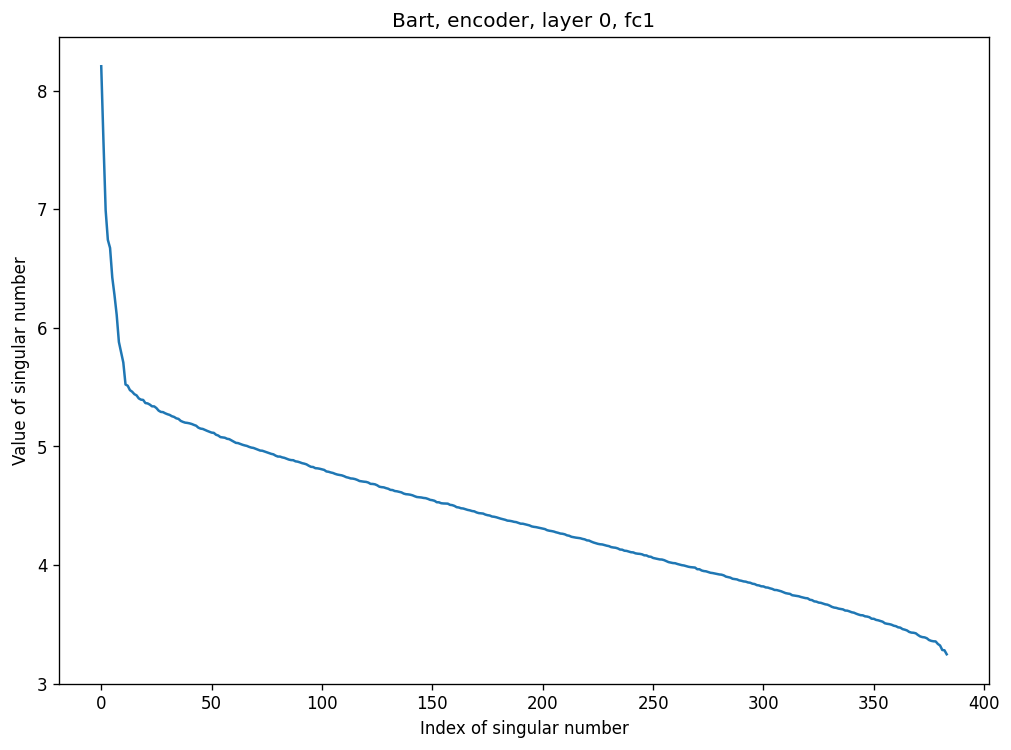

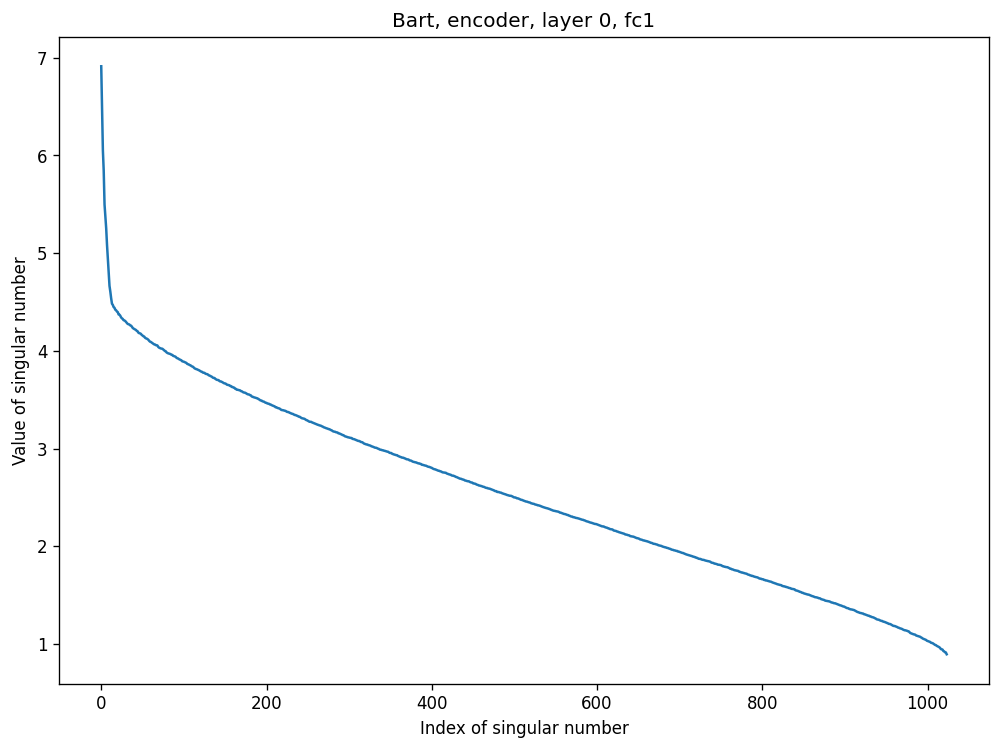

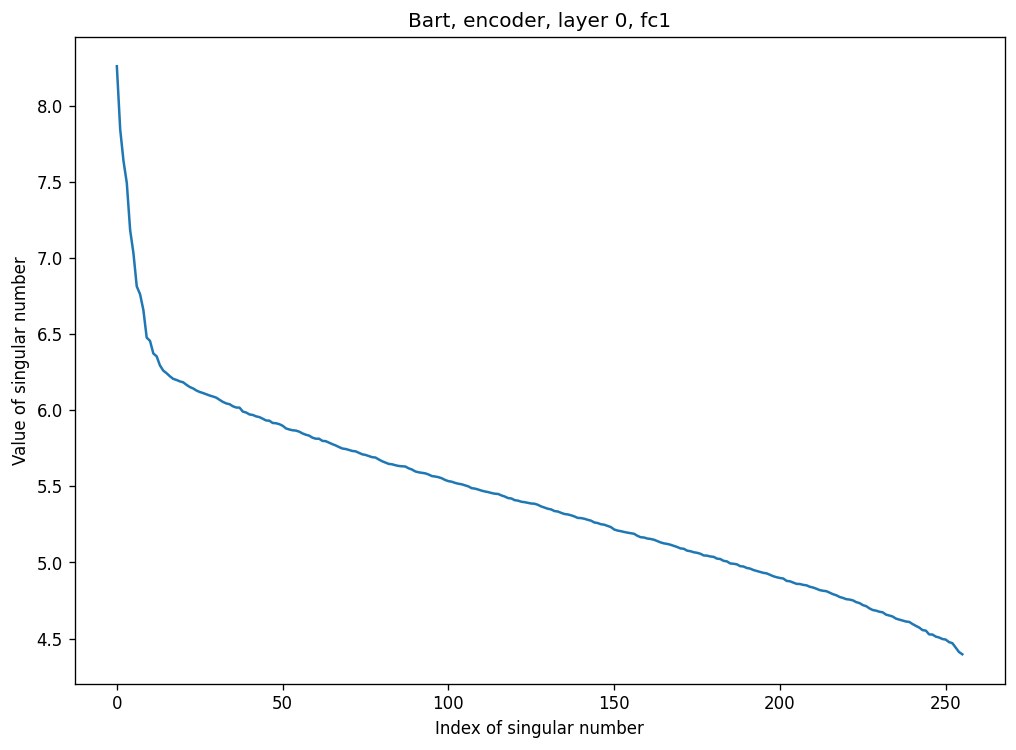

 17%|██████████████████▊                                                                                              | 1/6 [00:01<00:08,  1.69s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


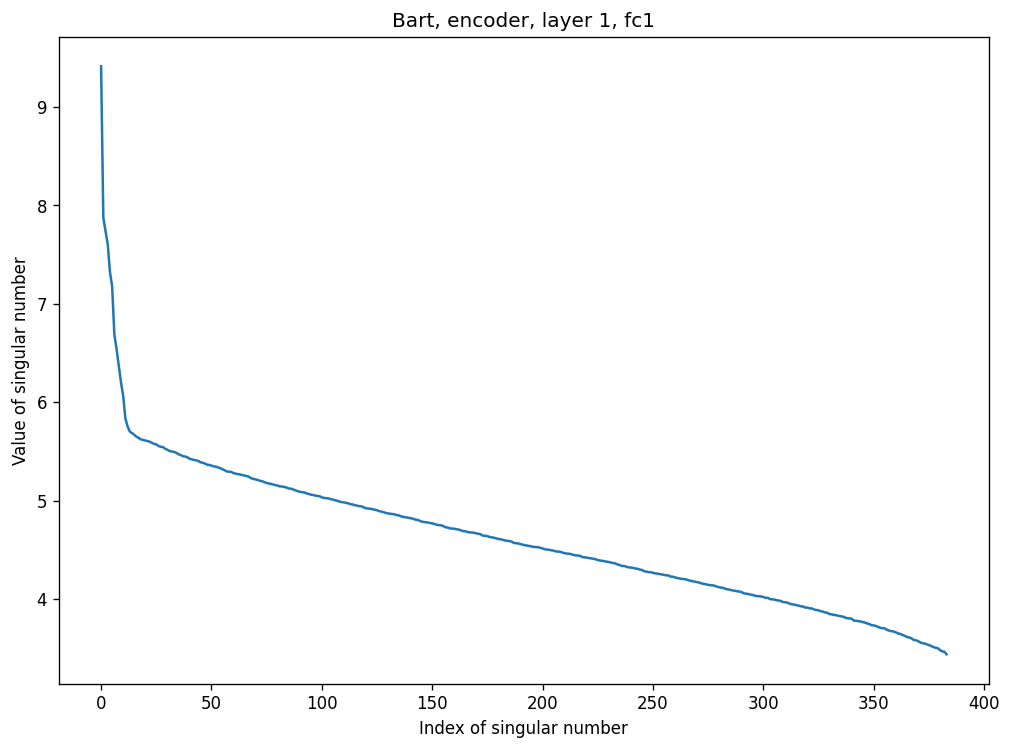

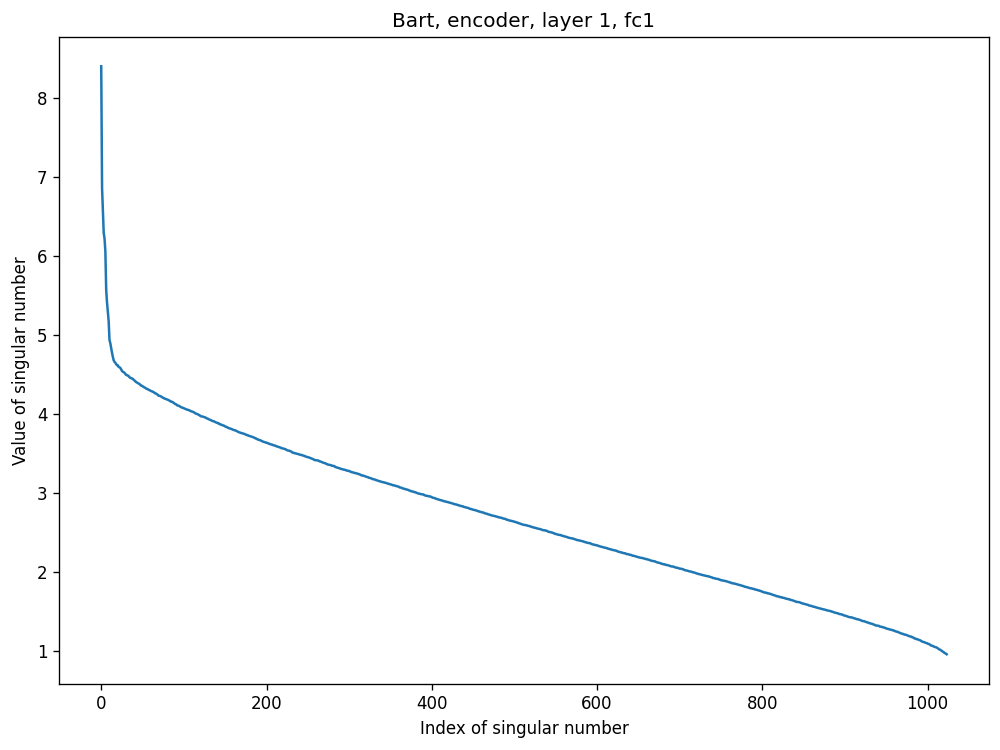

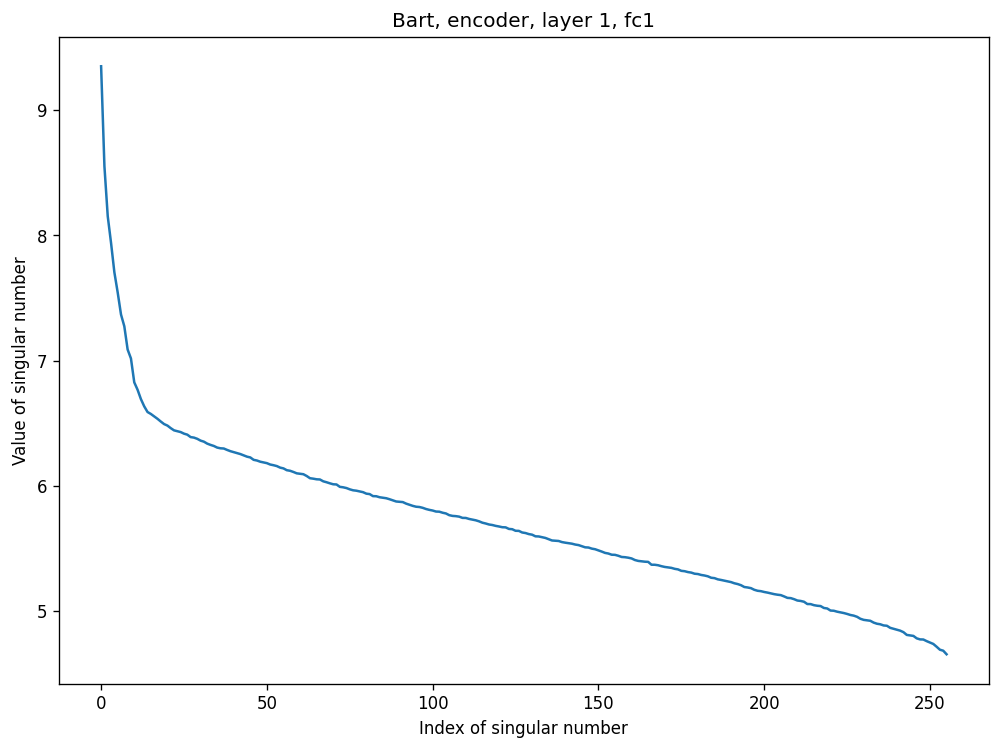

 33%|█████████████████████████████████████▋                                                                           | 2/6 [00:03<00:06,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


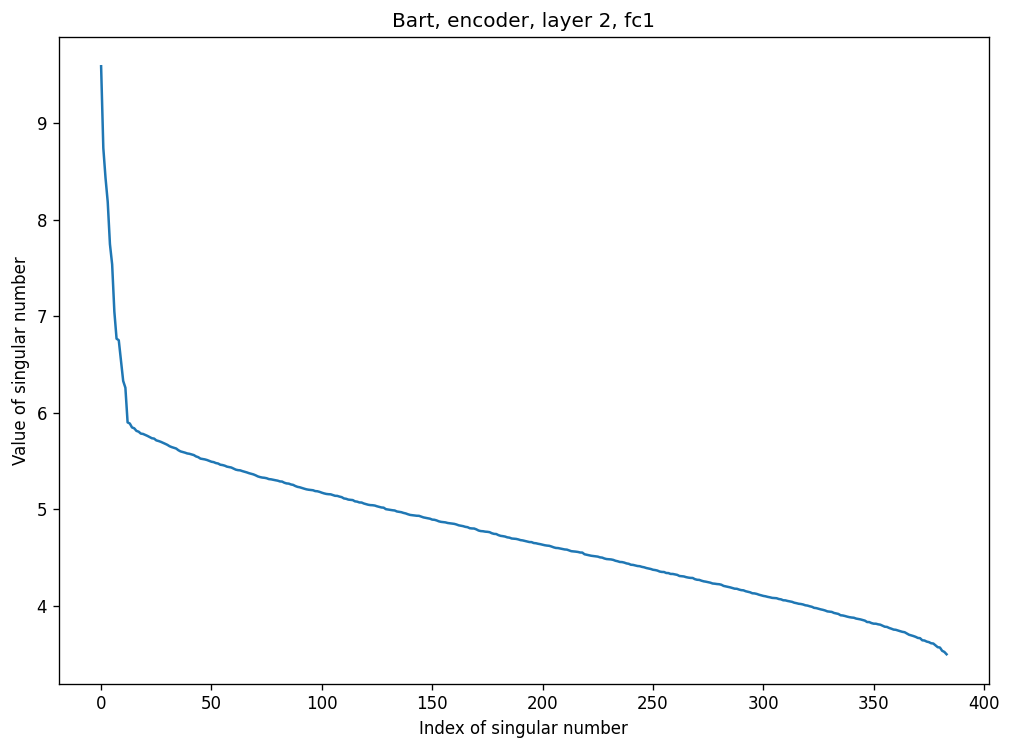

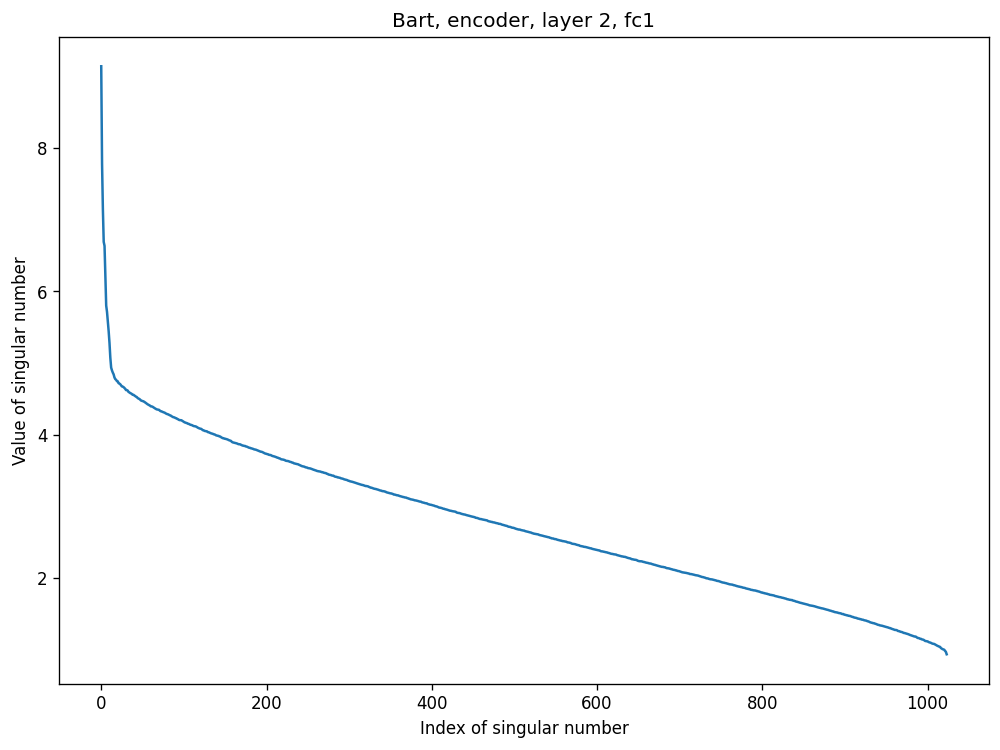

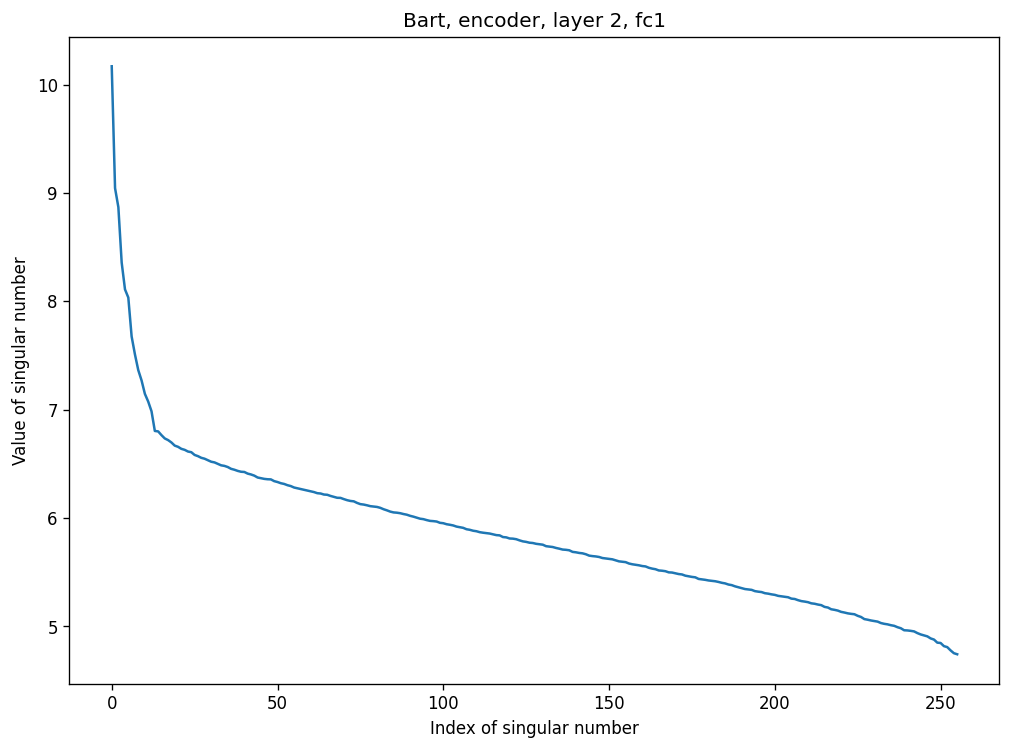

 50%|████████████████████████████████████████████████████████▌                                                        | 3/6 [00:05<00:05,  1.68s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


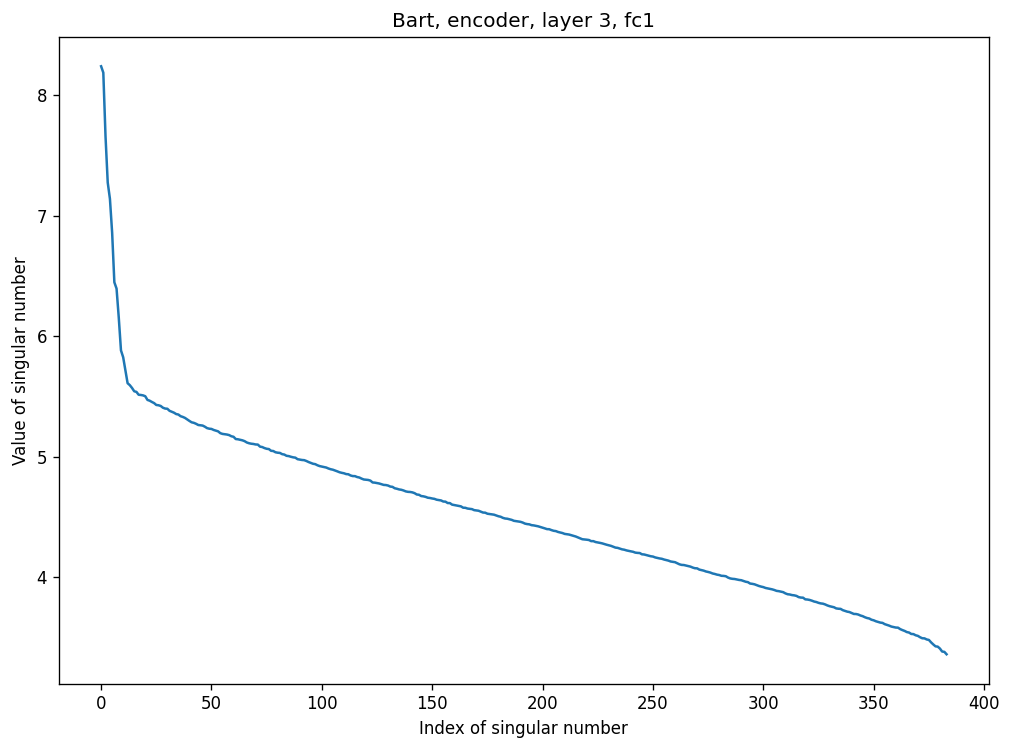

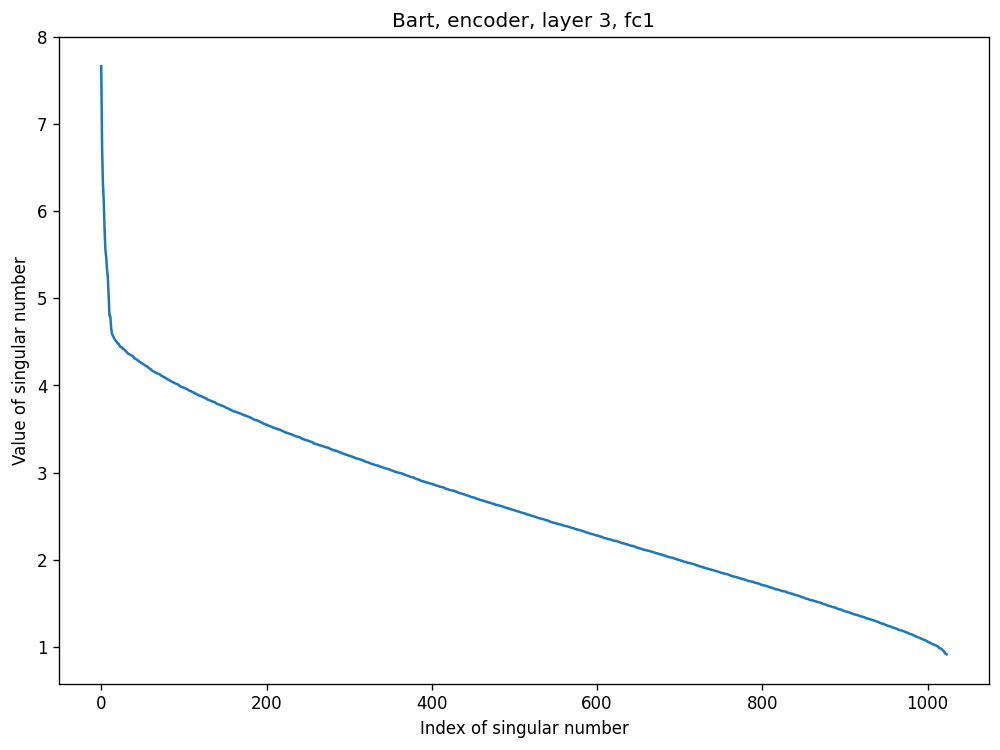

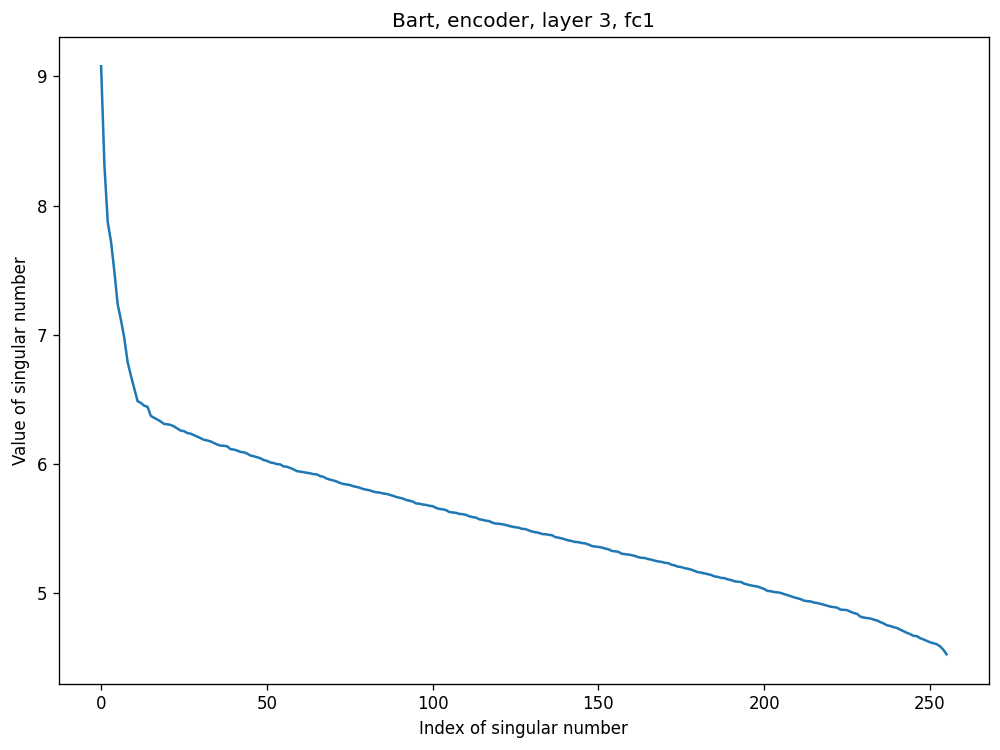

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 4/6 [00:06<00:03,  1.75s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


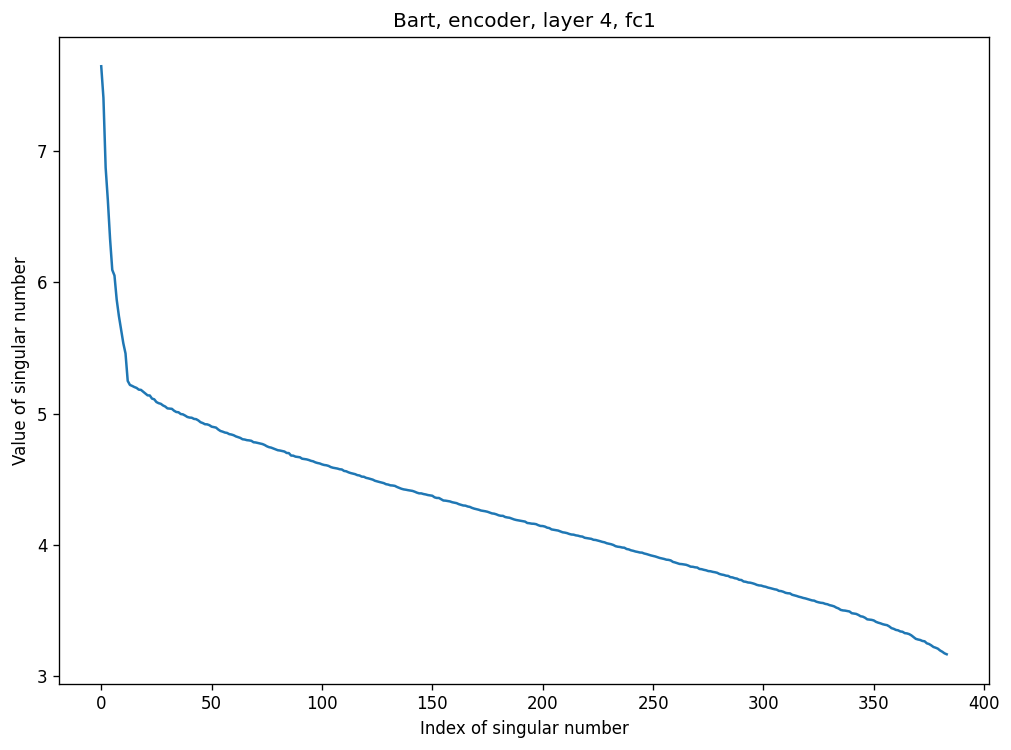

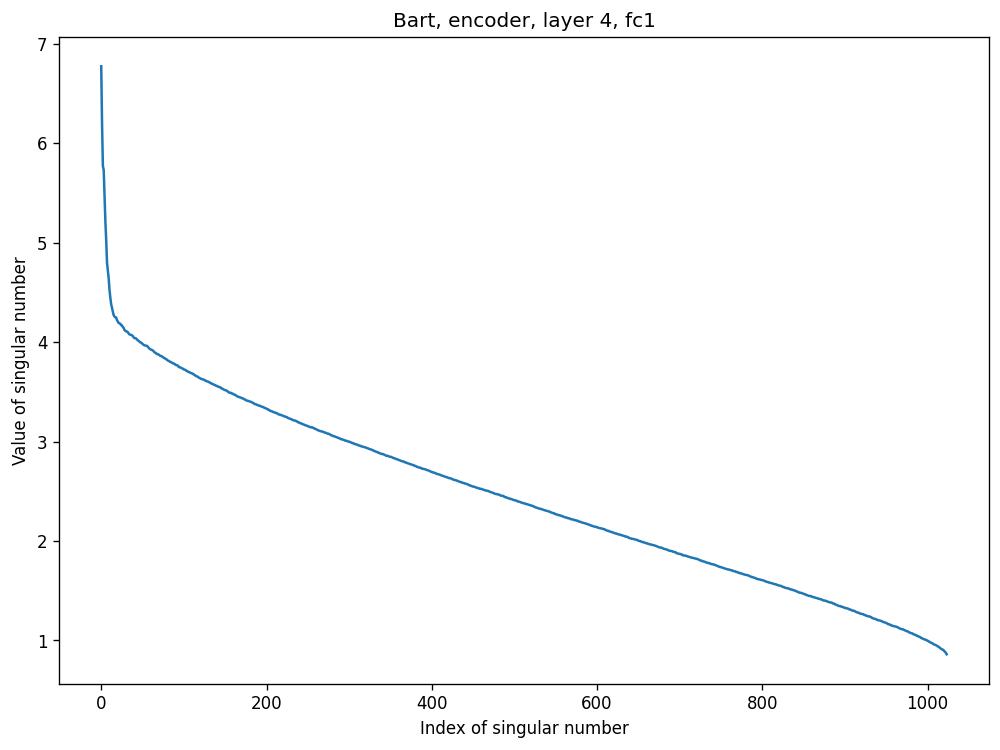

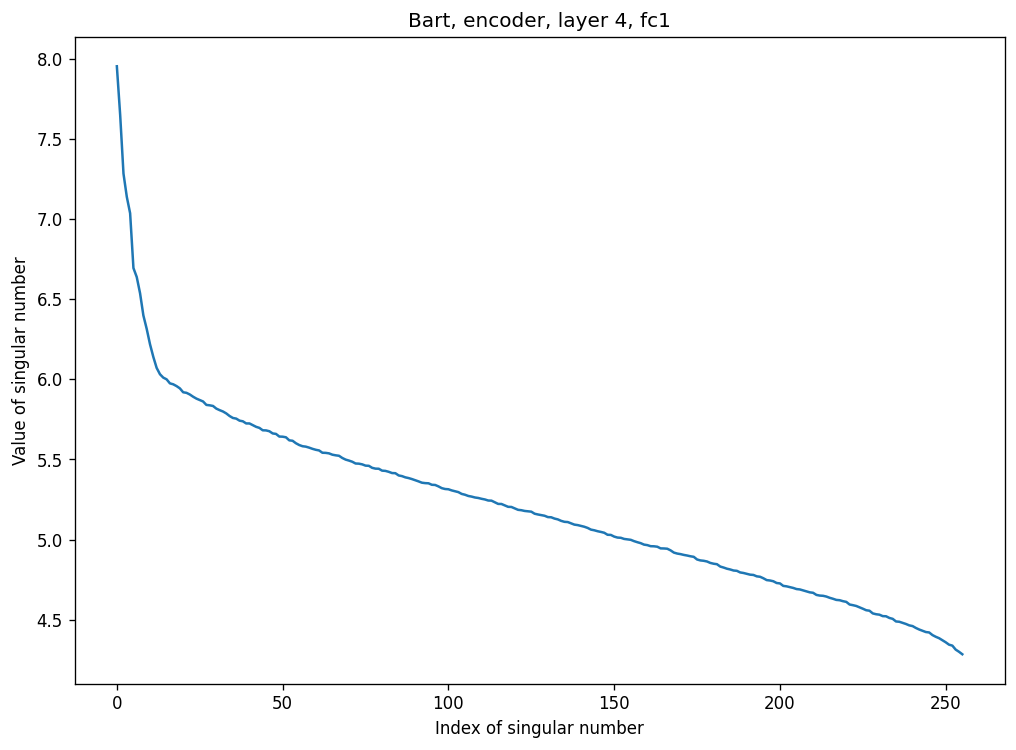

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5/6 [00:08<00:01,  1.72s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


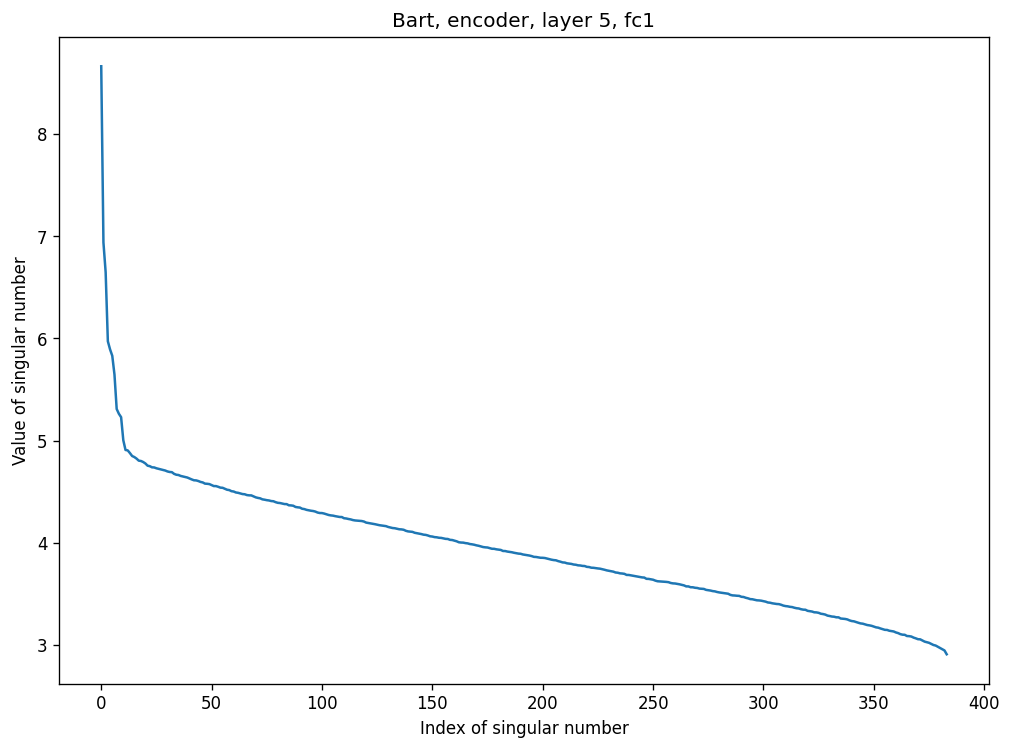

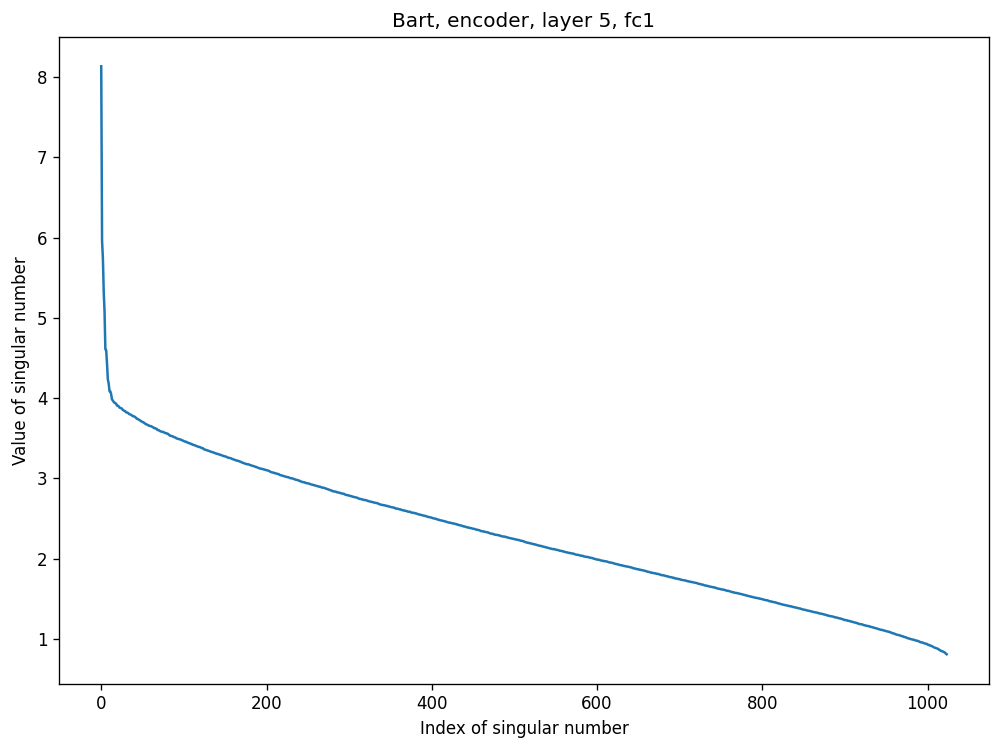

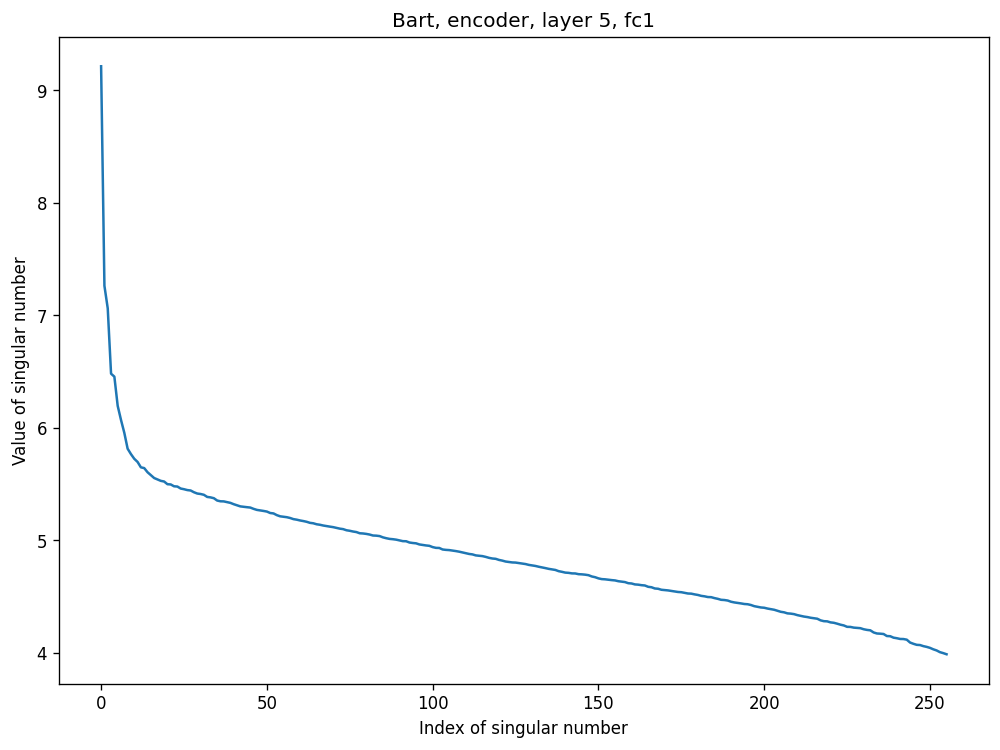

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]


In [31]:
ds = make_dataset_bart(bart.model, "encoder", "fc1", layer_to_compress=(4,2,5))
ds.to_csv("bart_encoder_fc1_dataset.csv", index=False)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)


  0%|                                                                                                                         | 0/6 [00:00<?, ?it/s]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


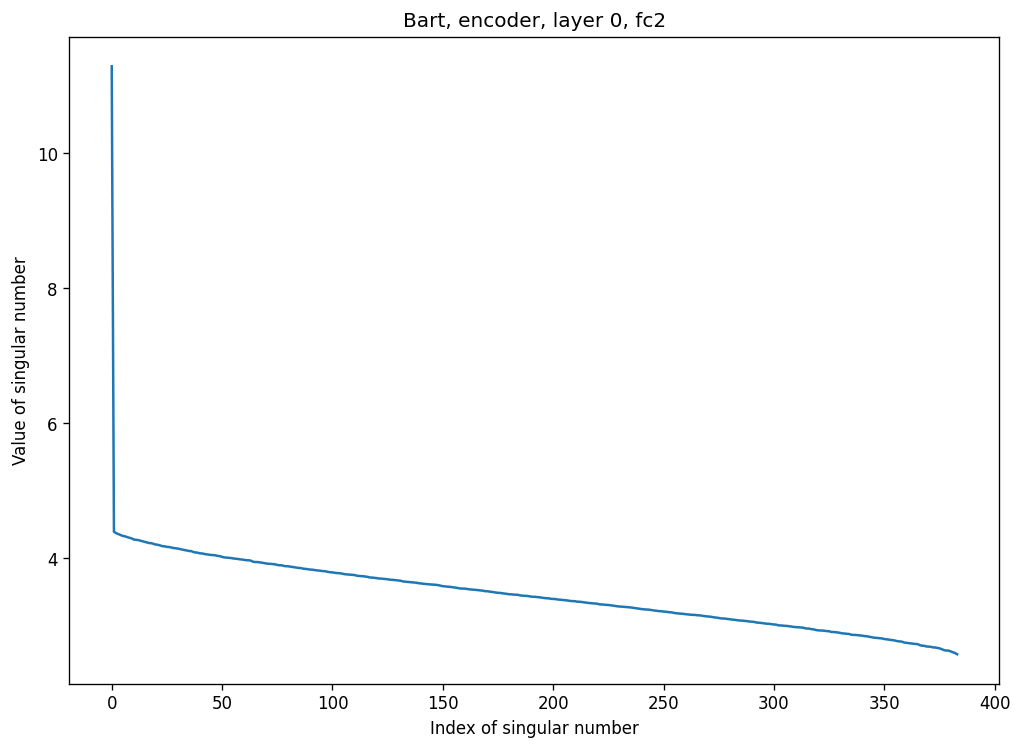

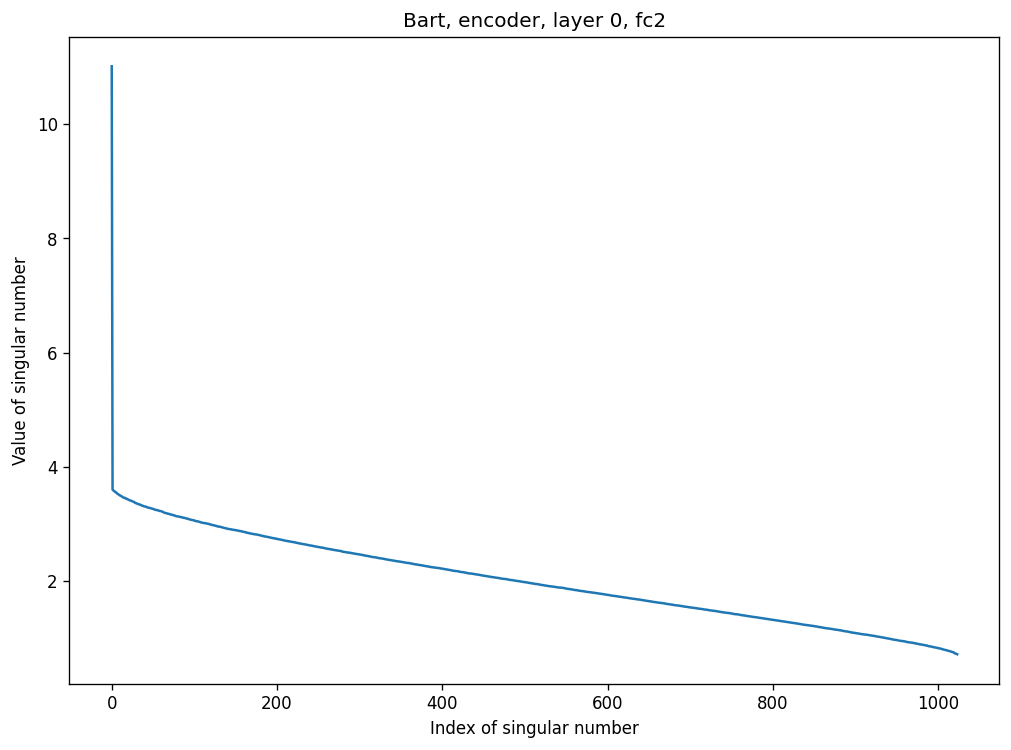

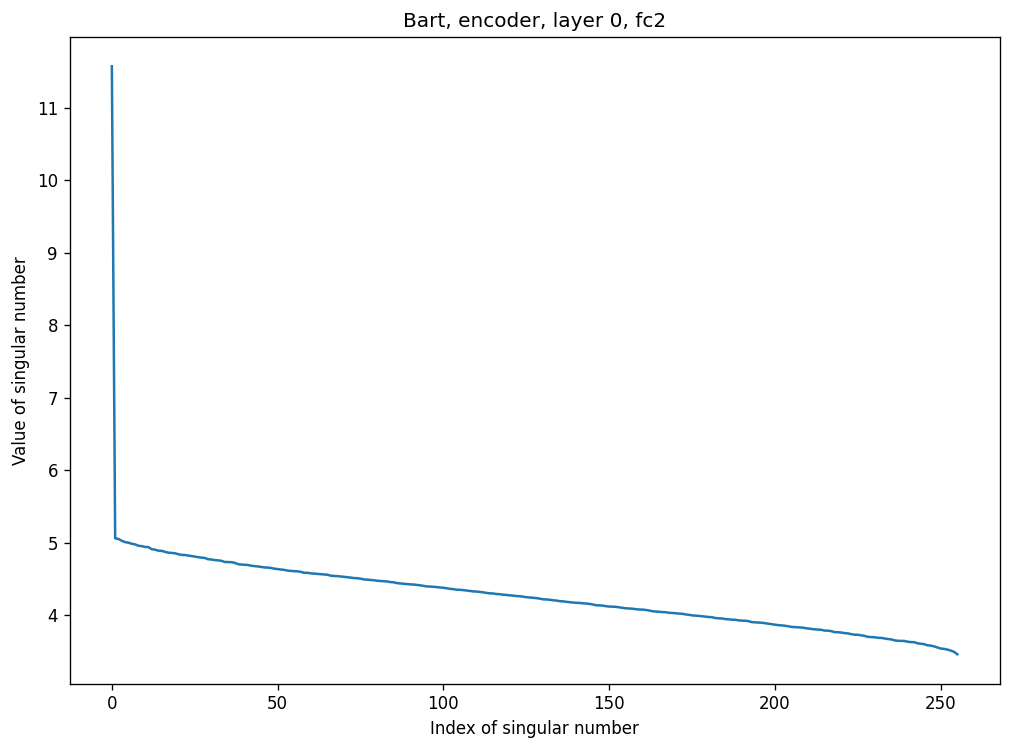

 17%|██████████████████▊                                                                                              | 1/6 [00:01<00:08,  1.68s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


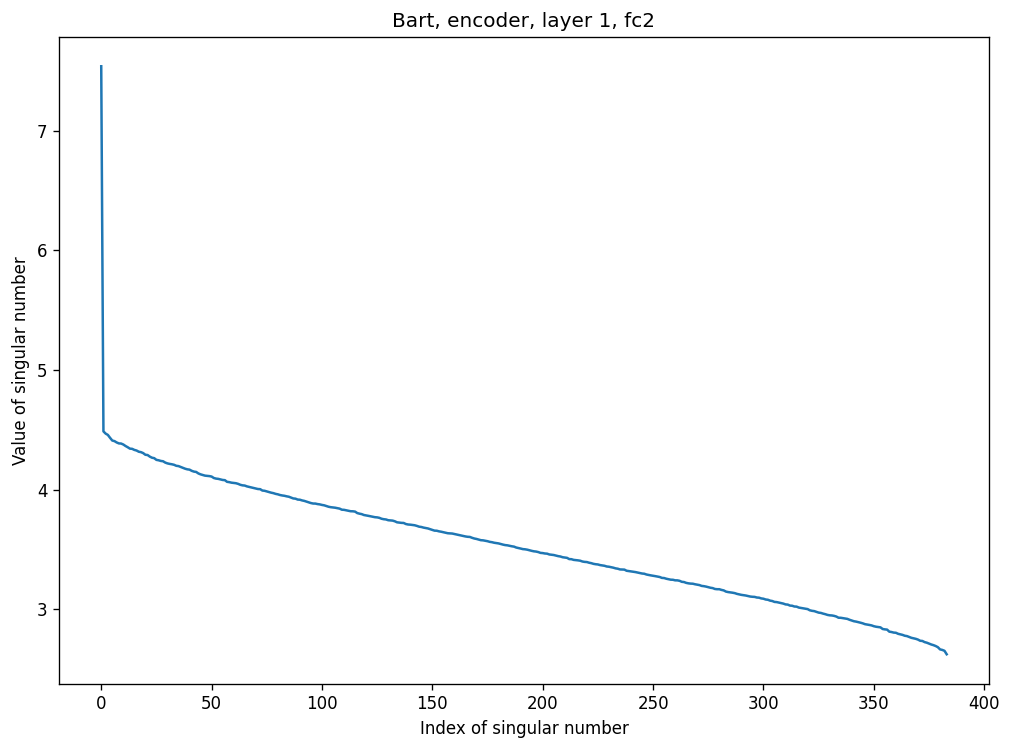

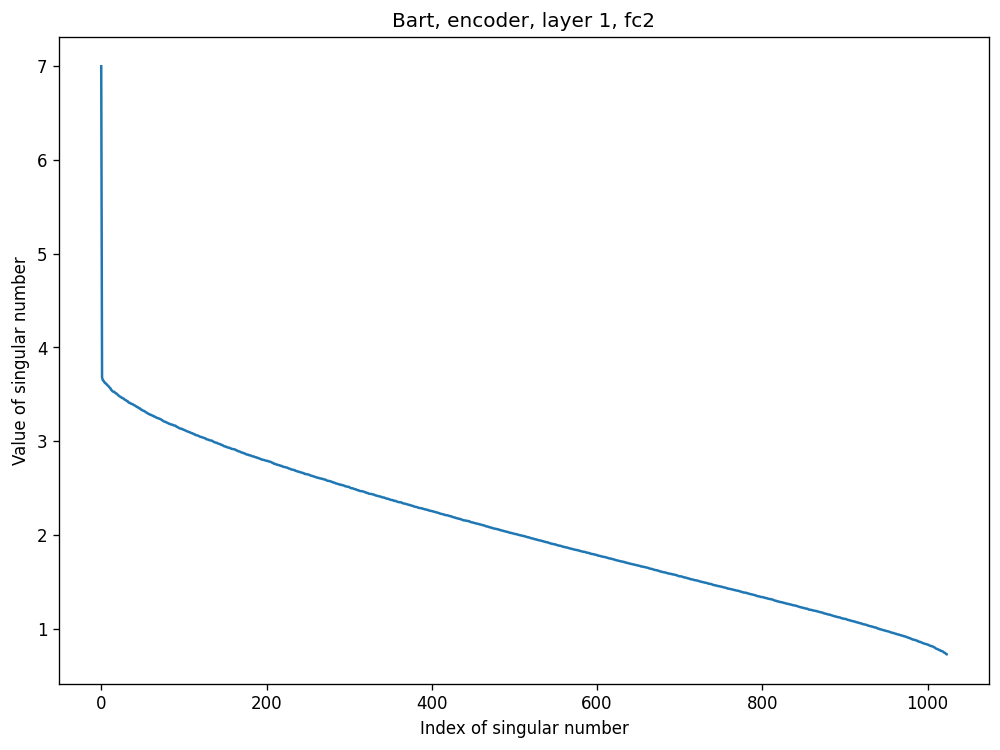

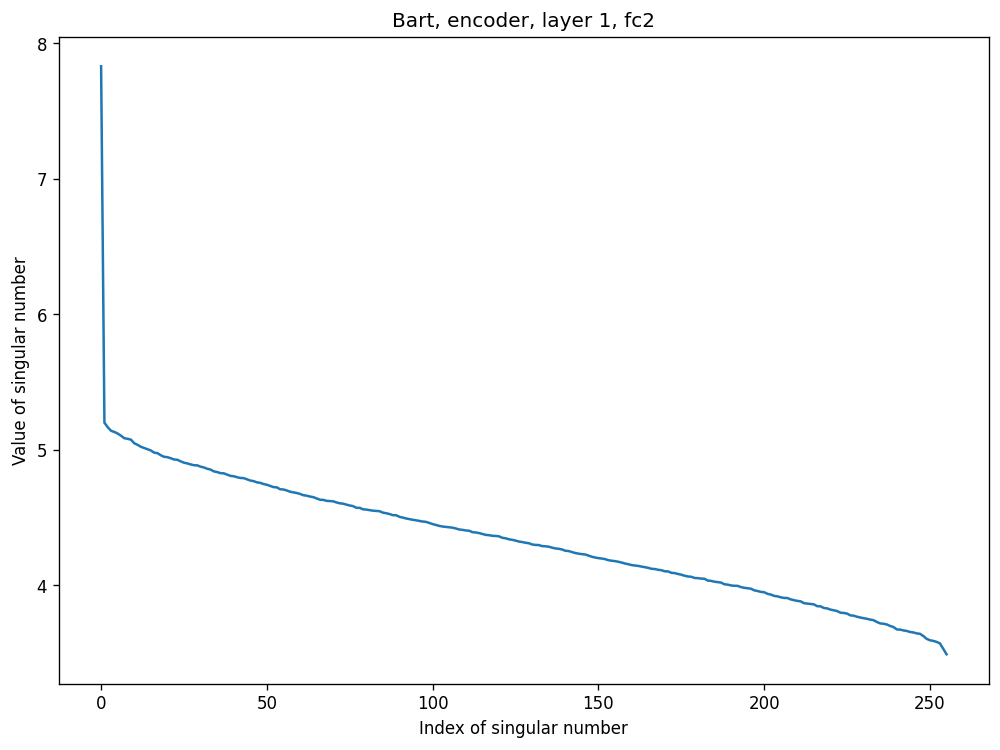

 33%|█████████████████████████████████████▋                                                                           | 2/6 [00:03<00:06,  1.67s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


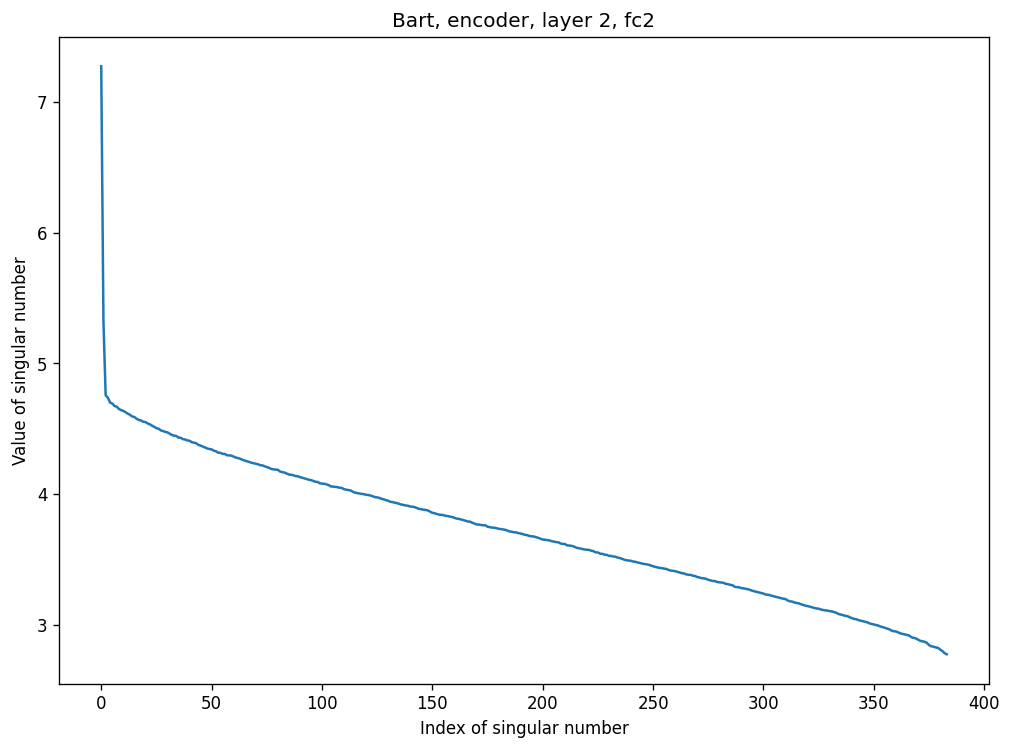

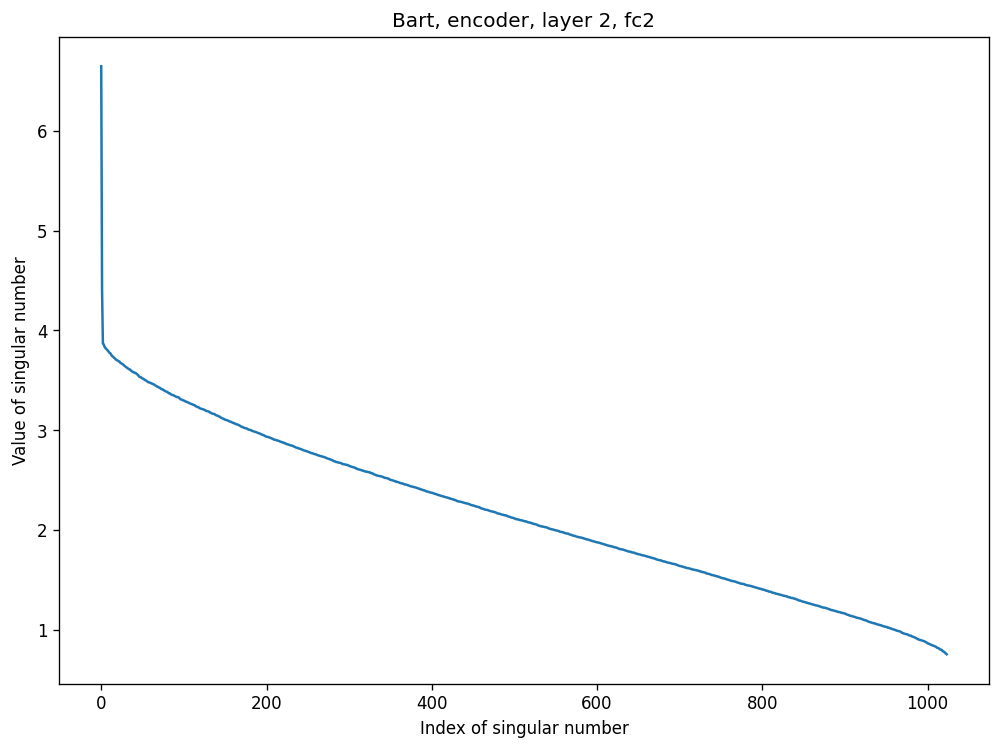

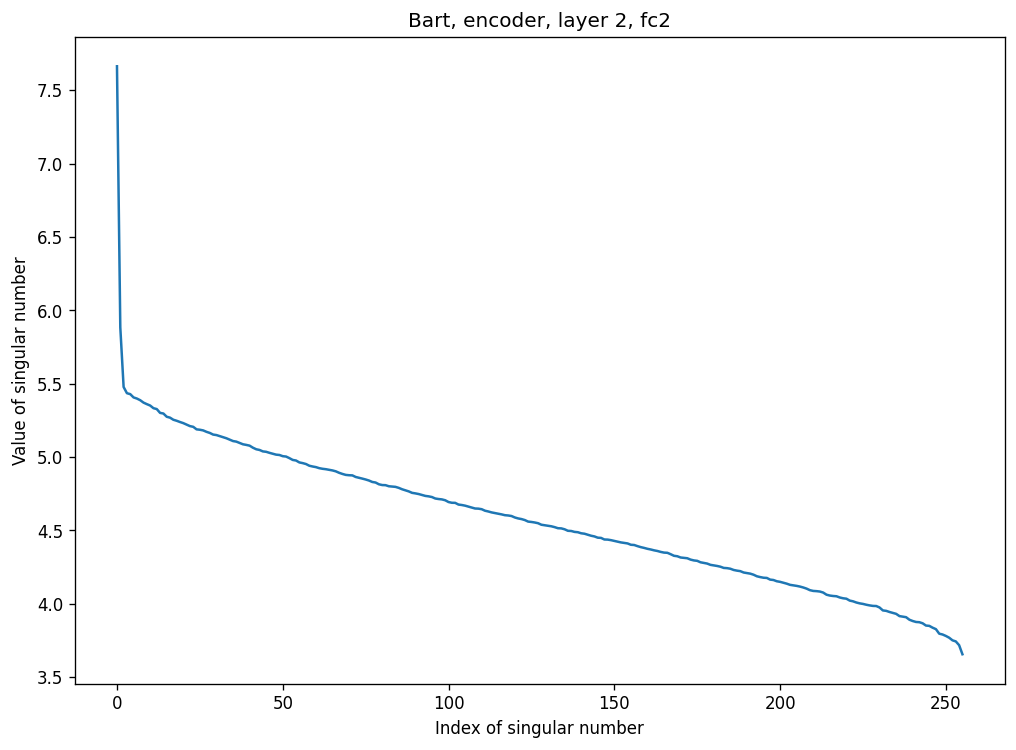

 50%|████████████████████████████████████████████████████████▌                                                        | 3/6 [00:05<00:05,  1.67s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


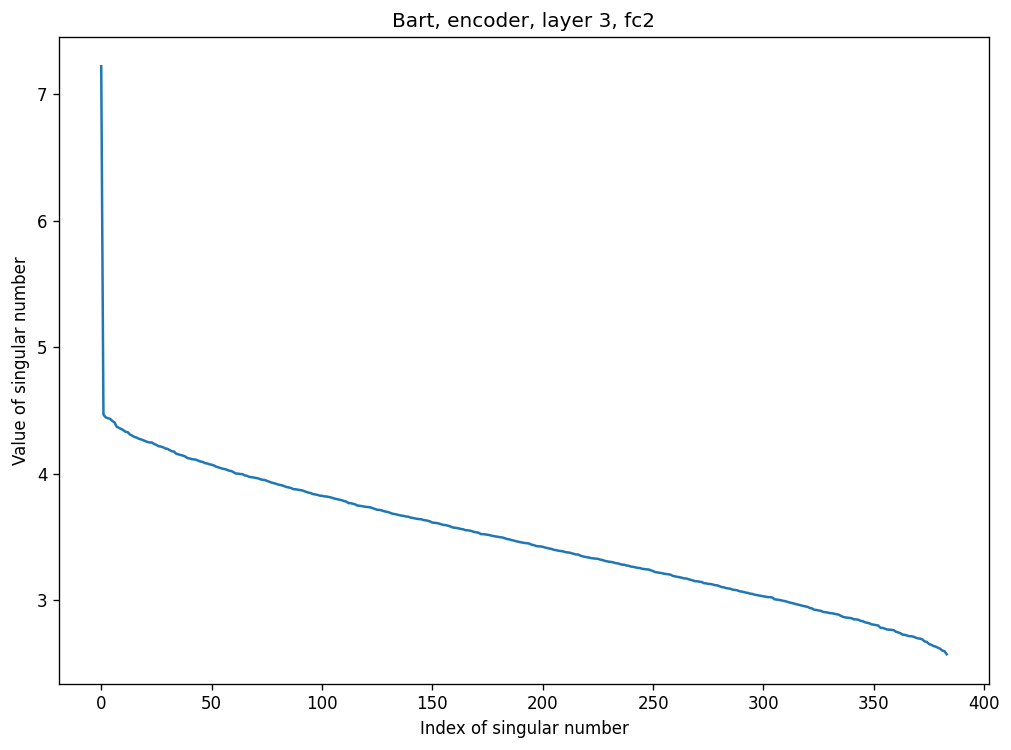

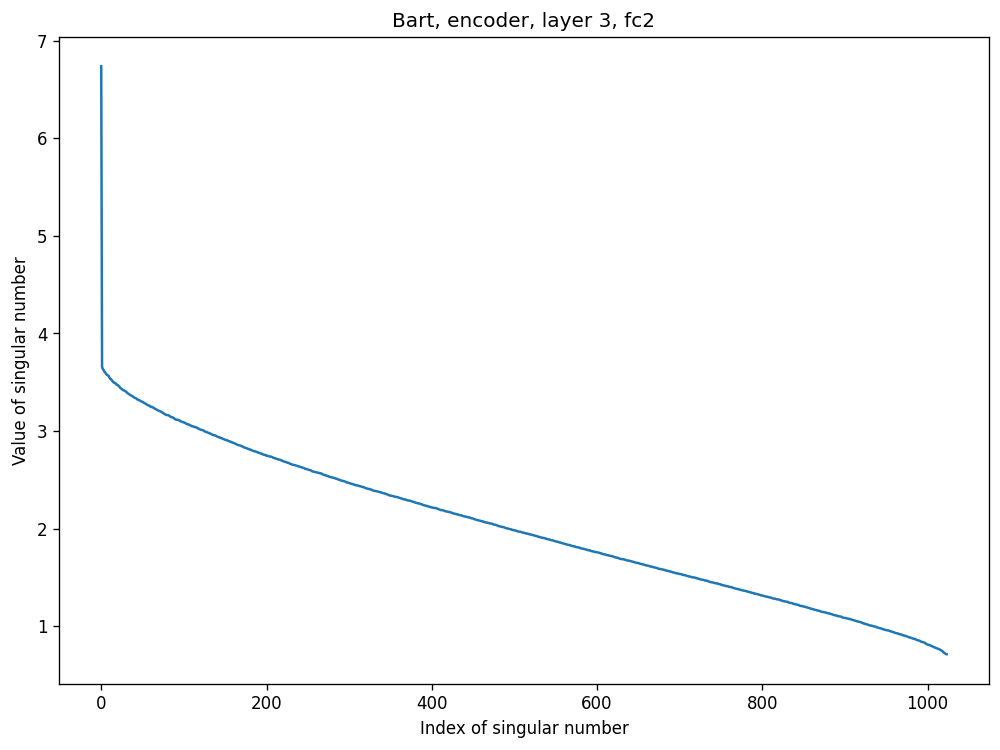

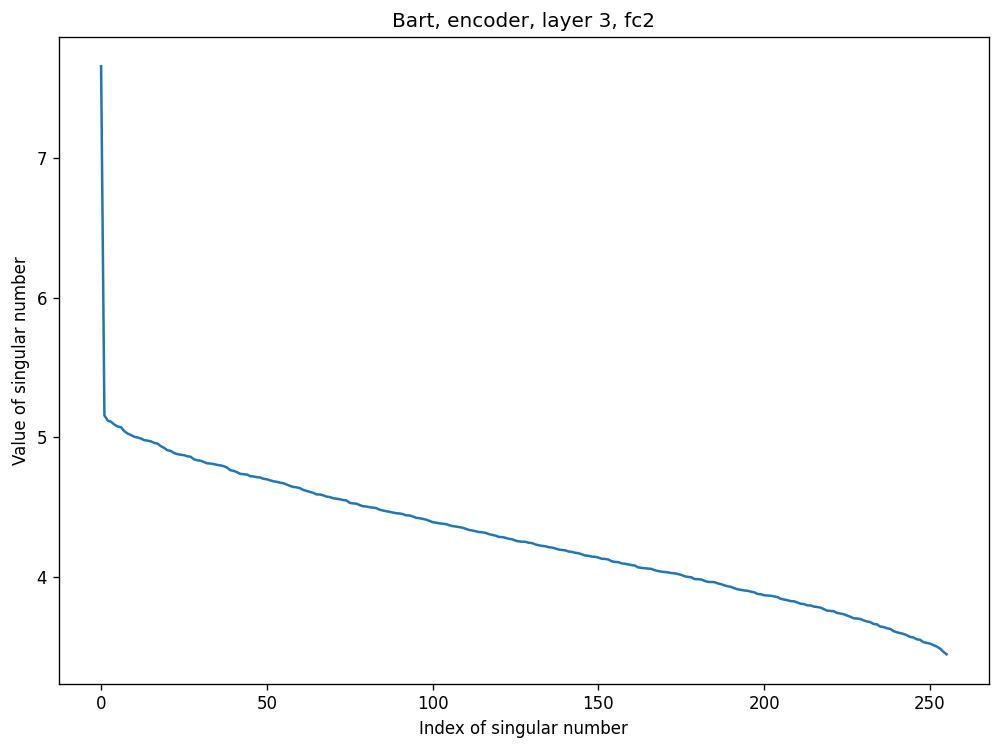

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 4/6 [00:06<00:03,  1.65s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


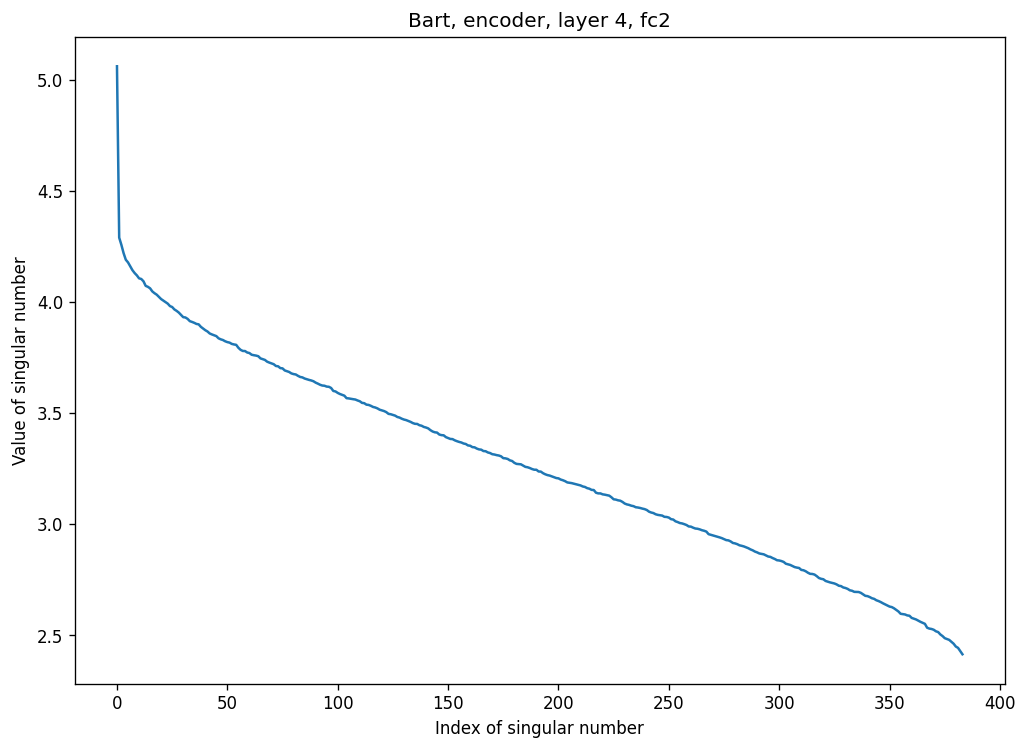

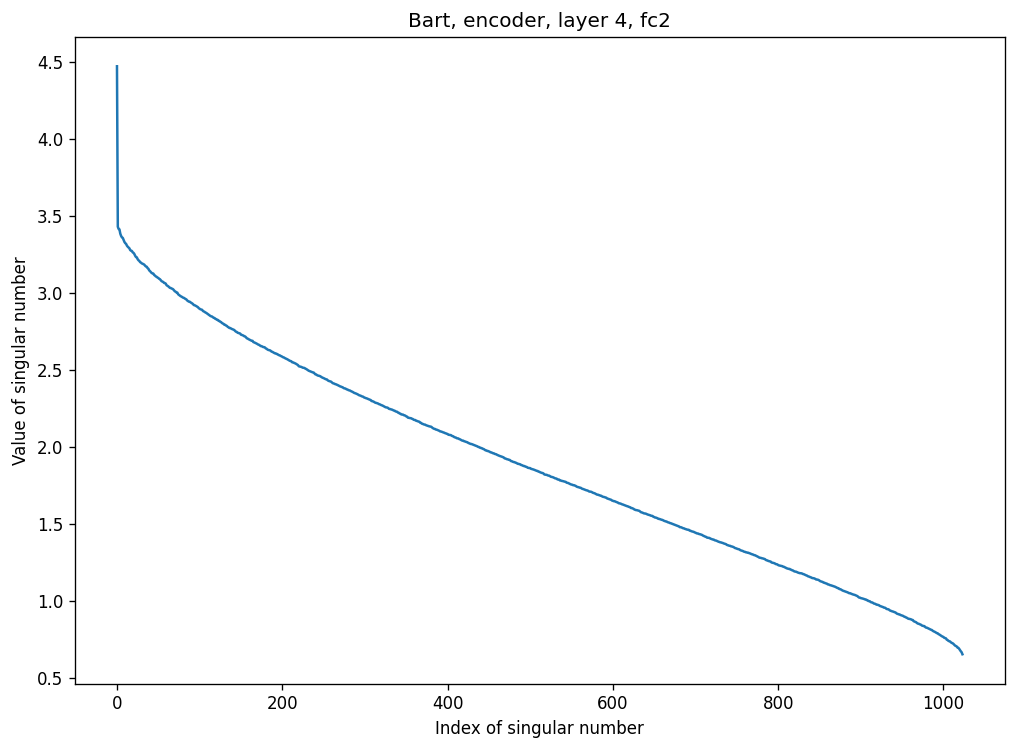

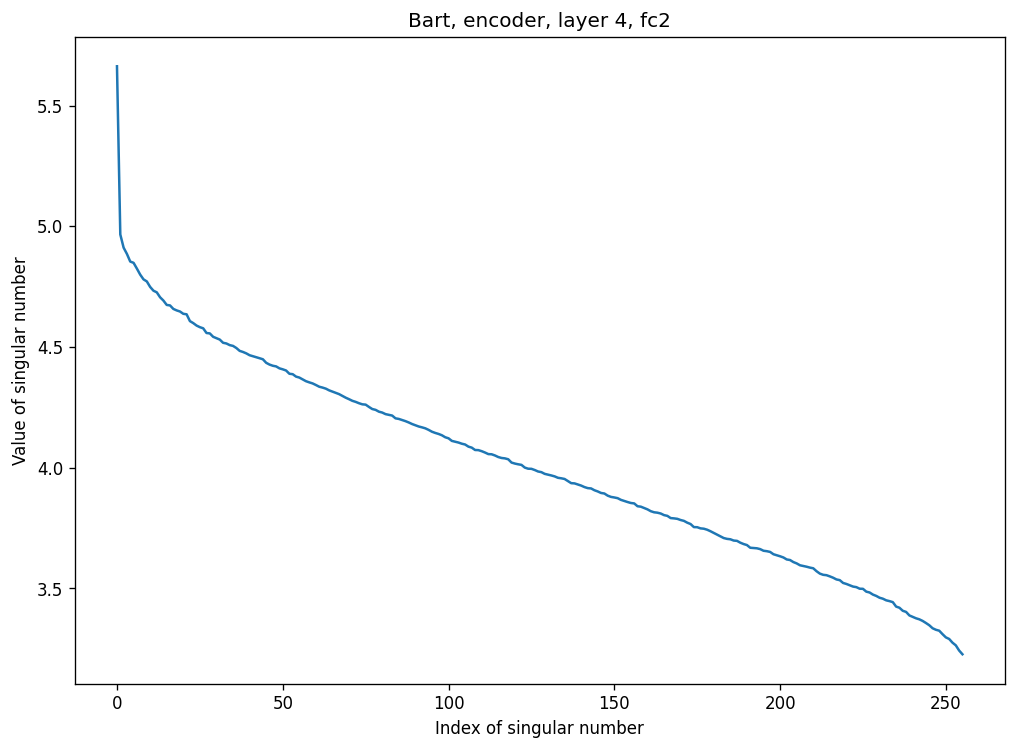

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5/6 [00:08<00:01,  1.66s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


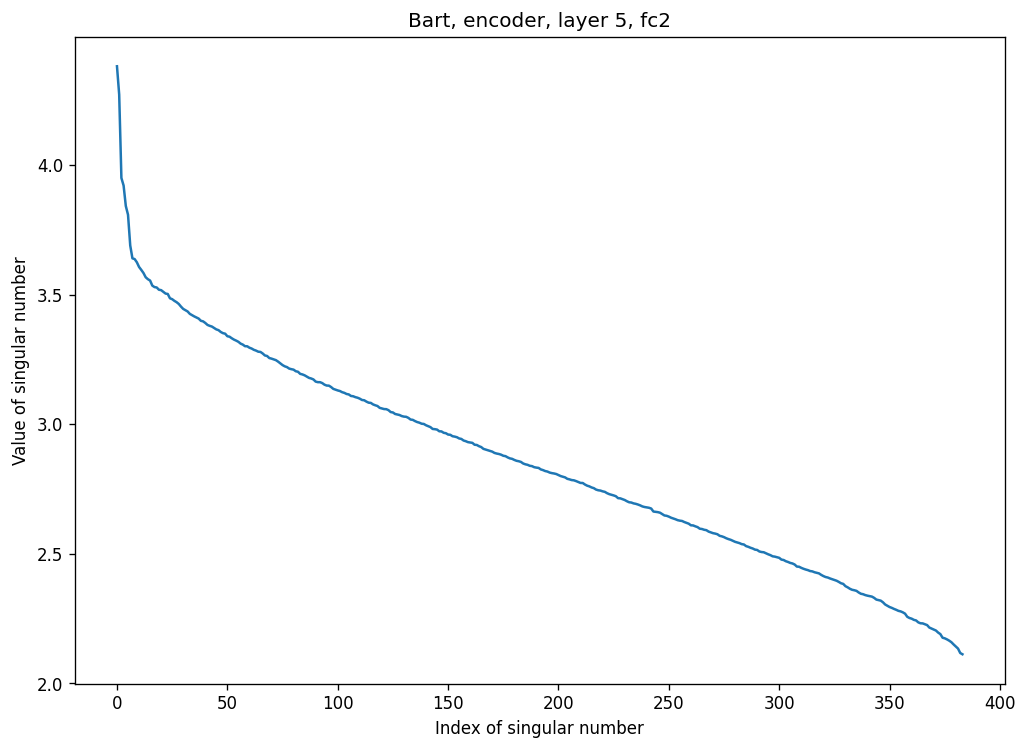

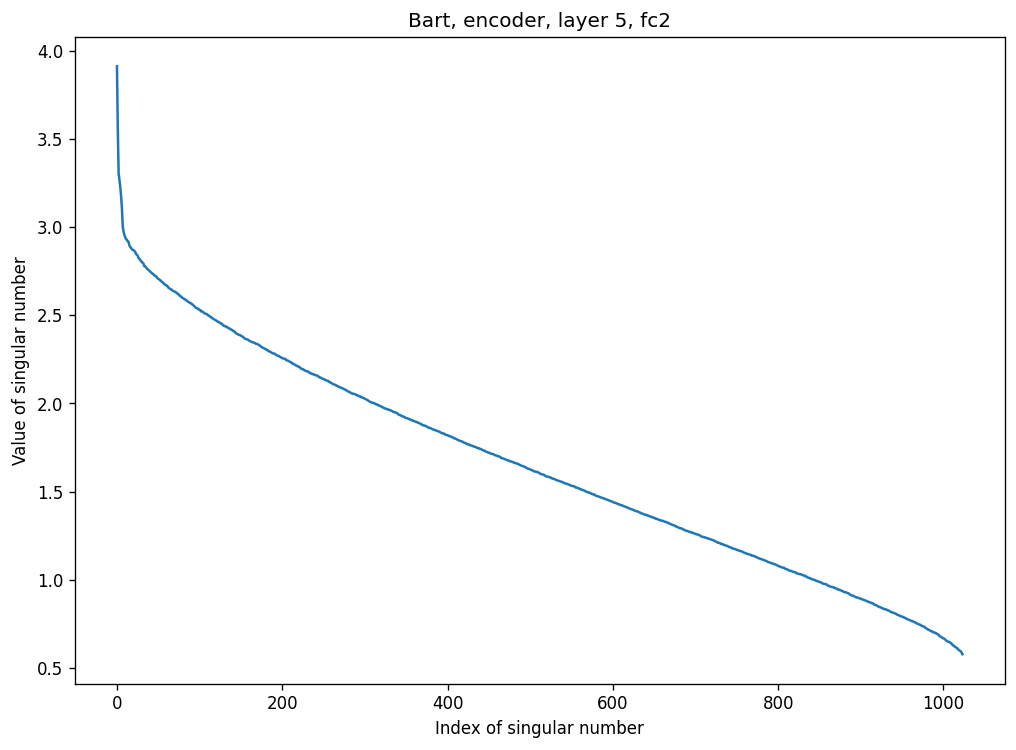

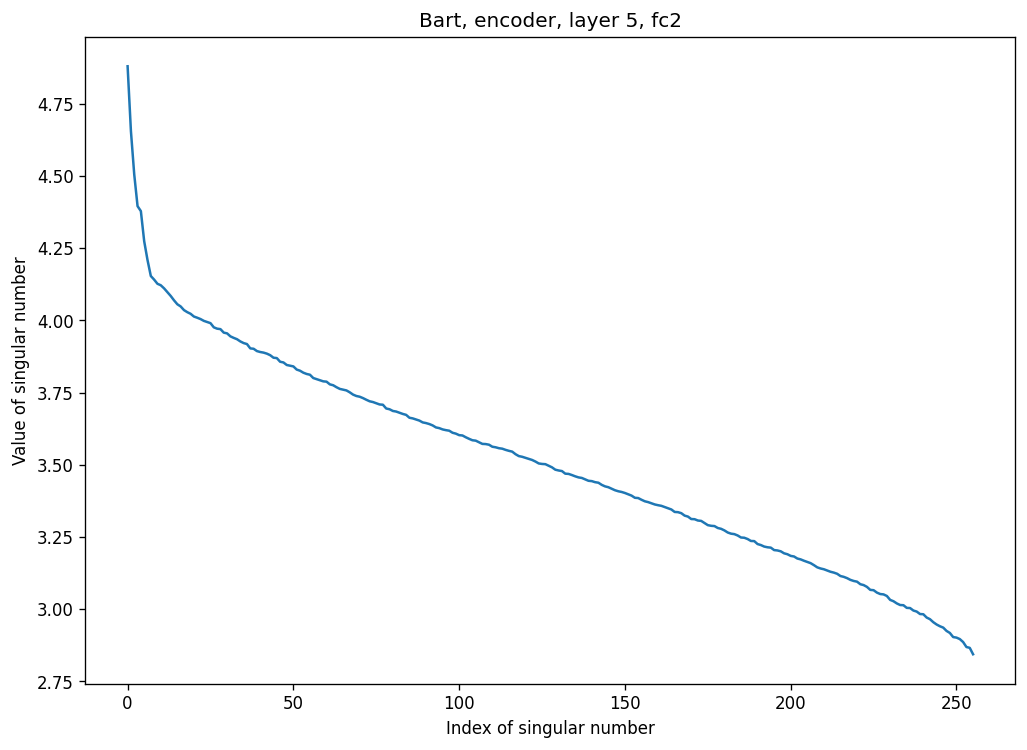

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


In [32]:
ds = make_dataset_bart(bart.model, "encoder", "fc2", layer_to_compress=(1,2,3))
ds.to_csv("bart_encoder_fc2_dataset.csv", index=False)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)


  0%|                                                                                                                         | 0/6 [00:00<?, ?it/s]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


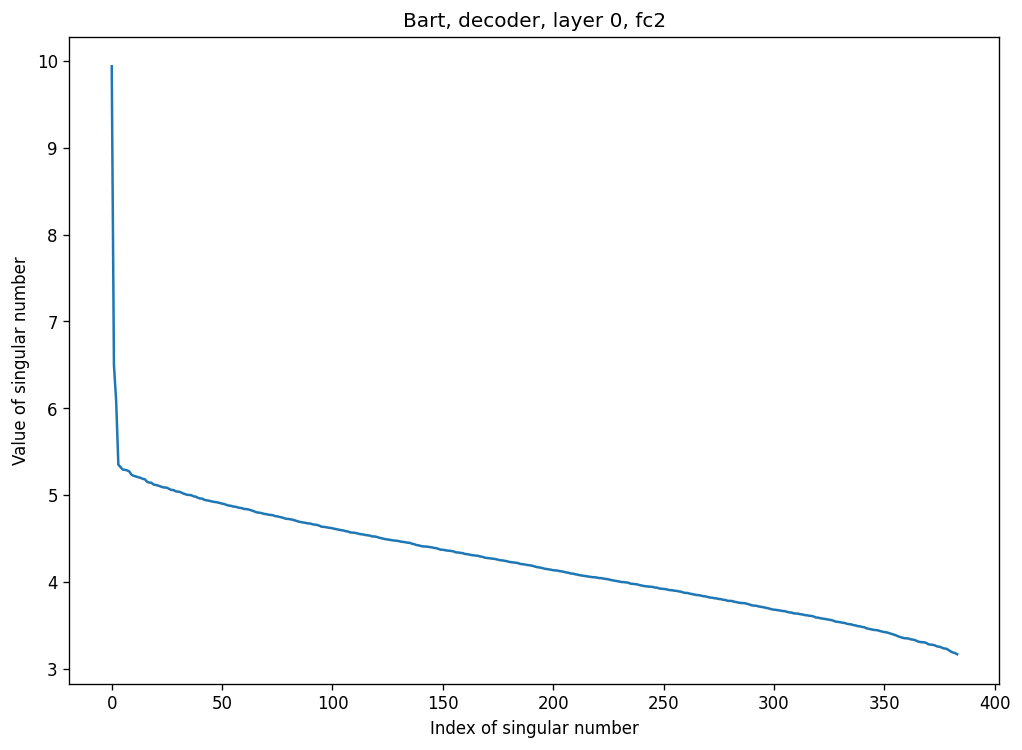

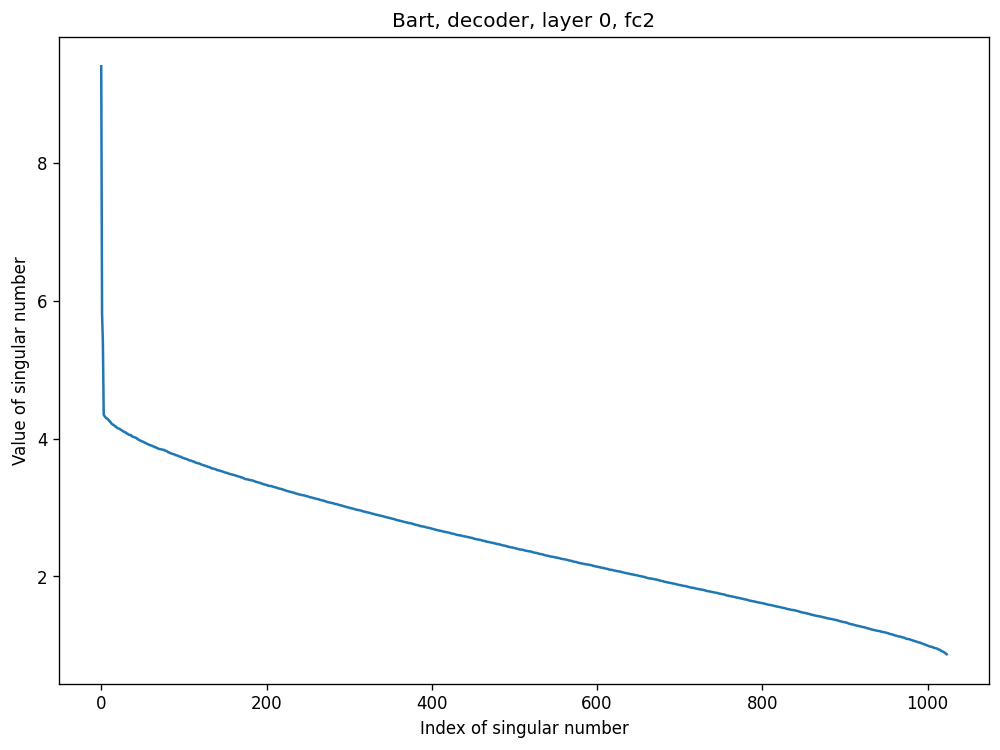

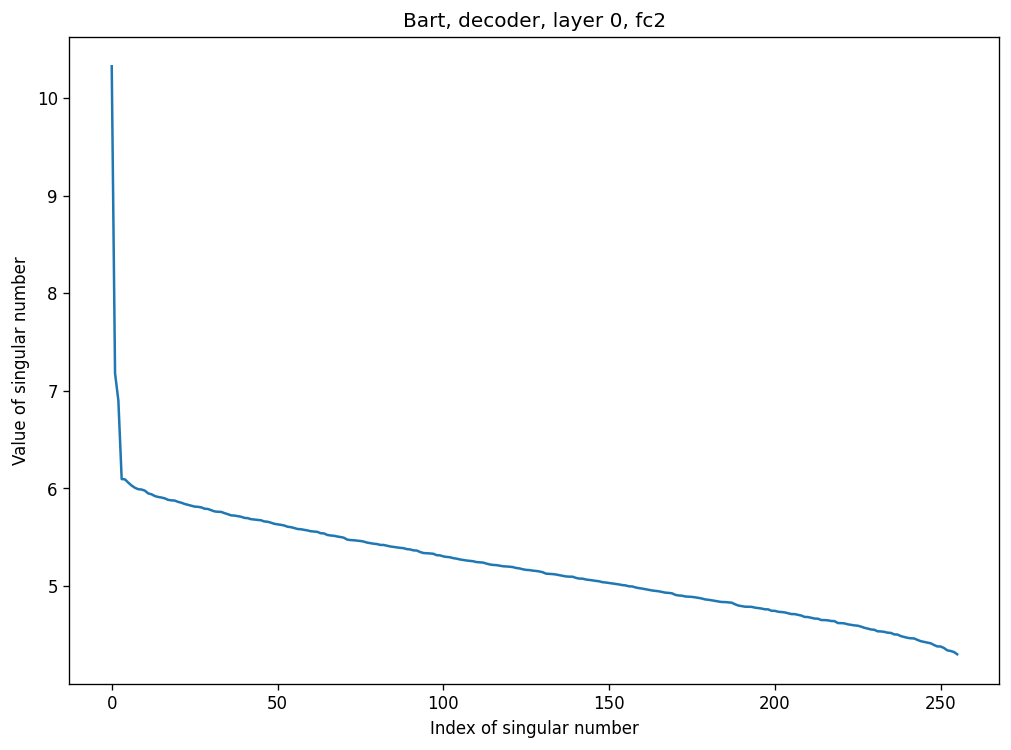

 17%|██████████████████▊                                                                                              | 1/6 [00:01<00:08,  1.65s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


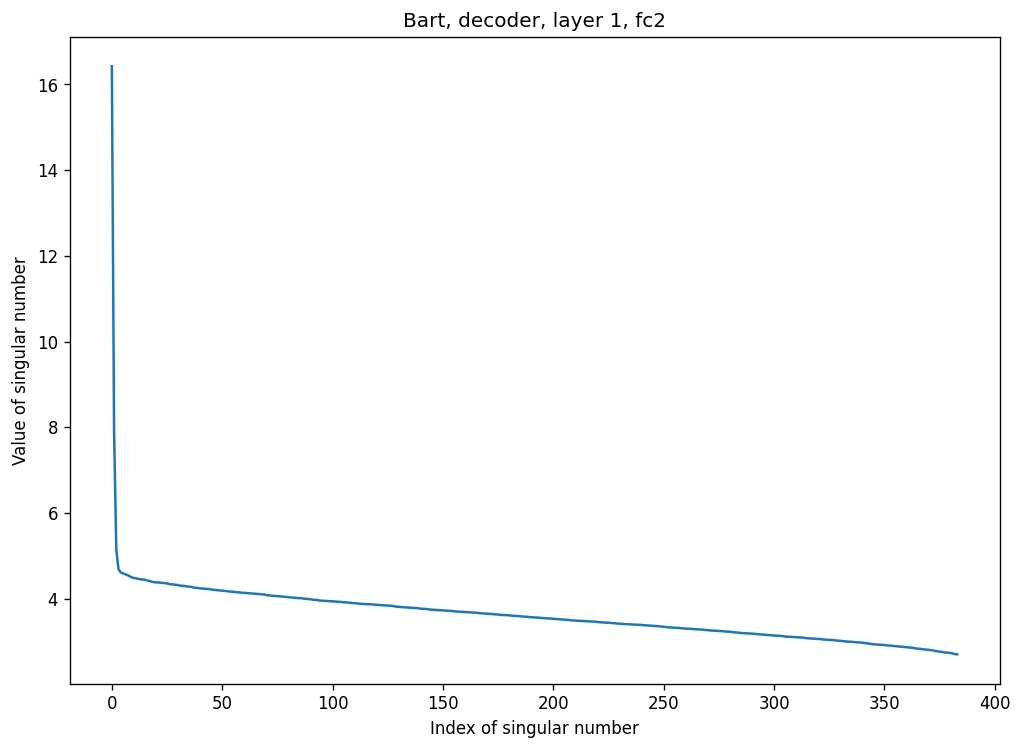

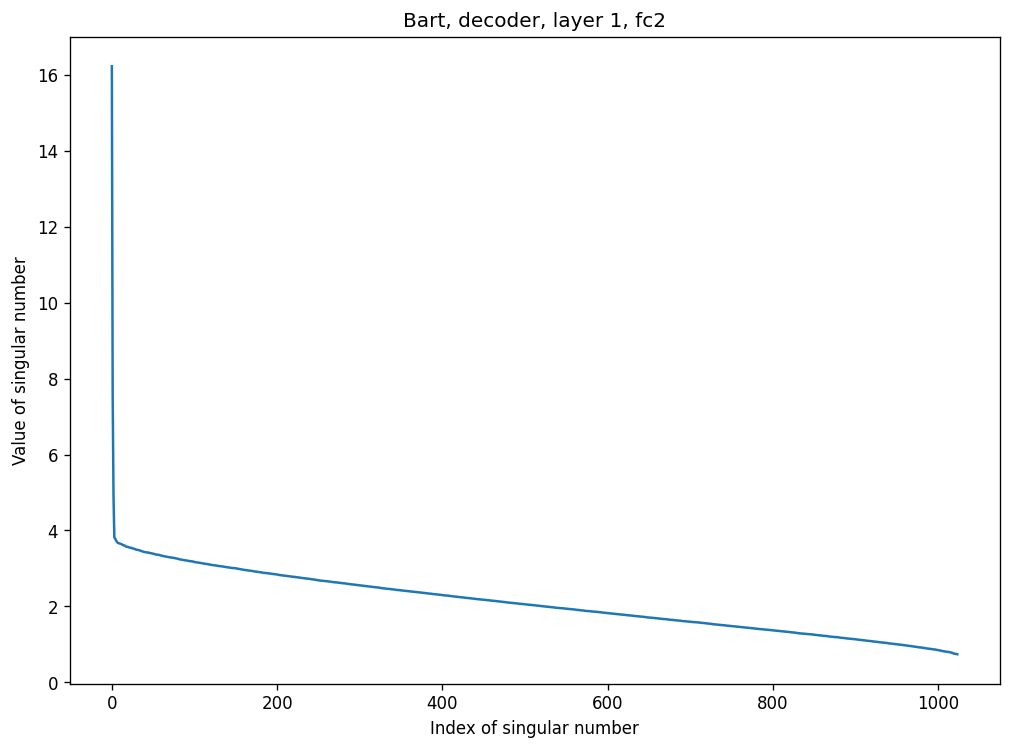

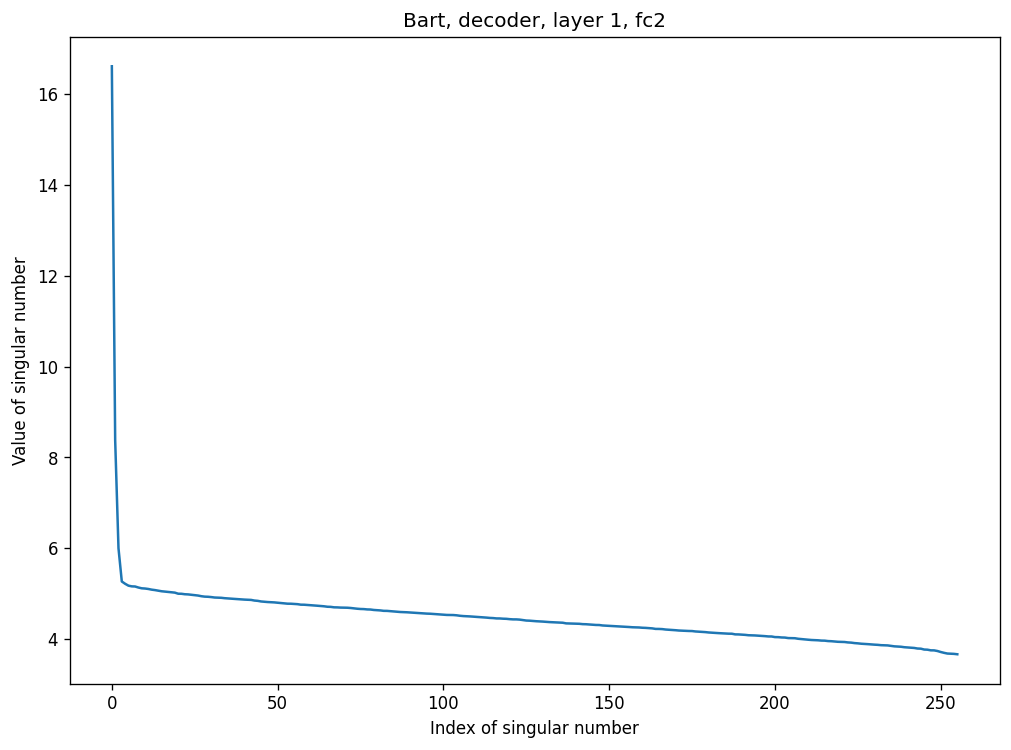

 33%|█████████████████████████████████████▋                                                                           | 2/6 [00:03<00:06,  1.65s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


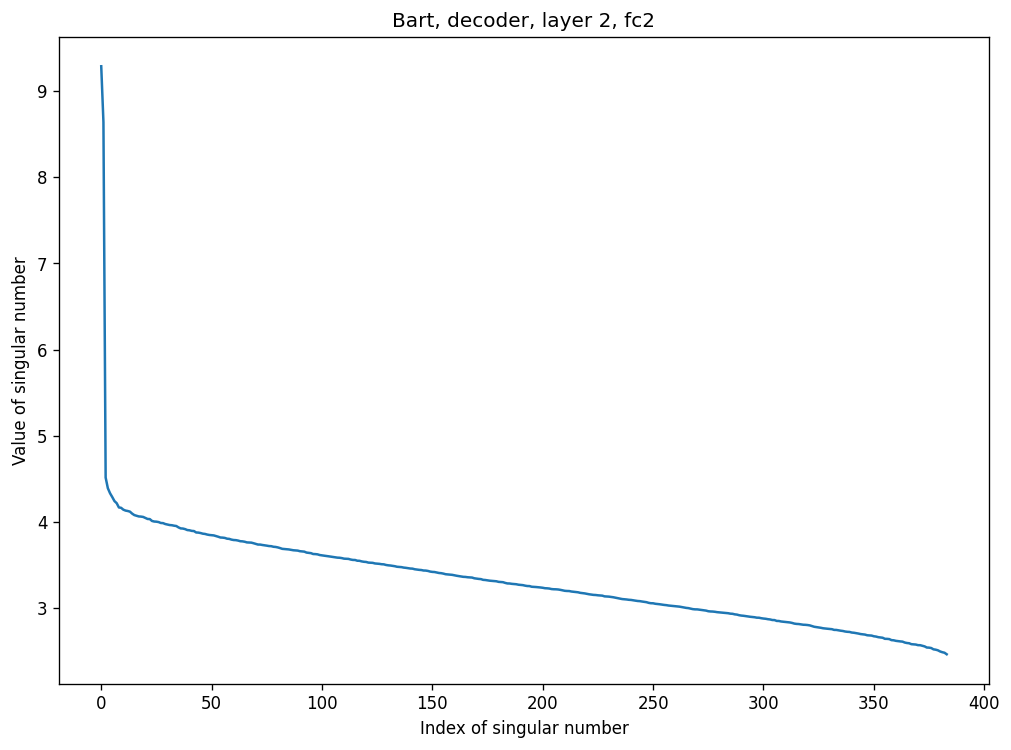

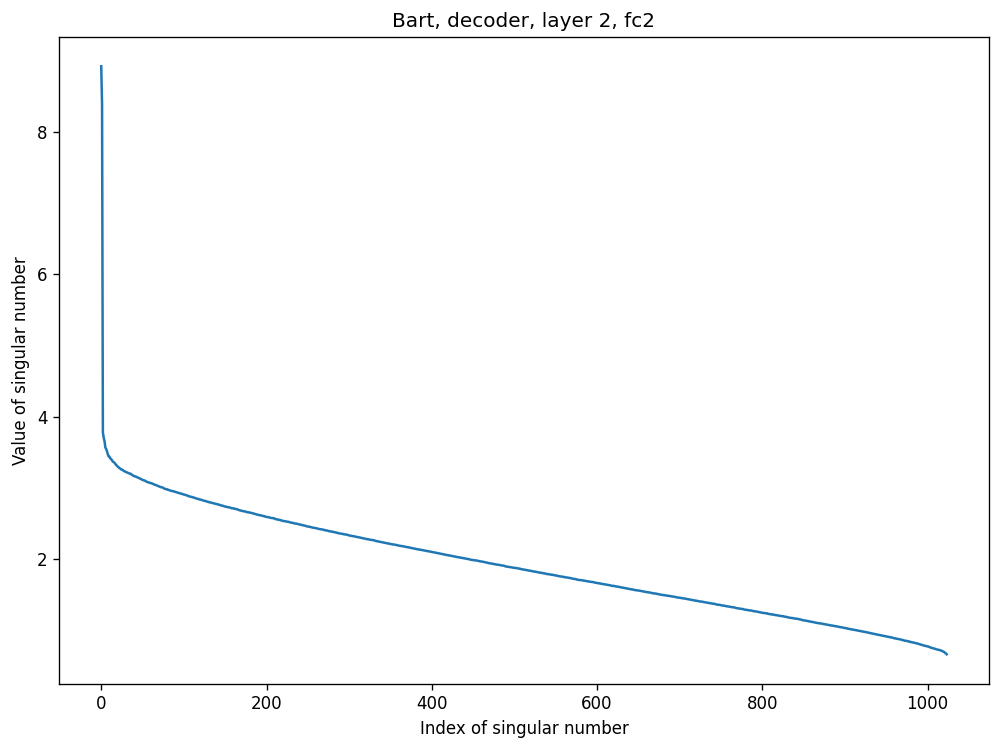

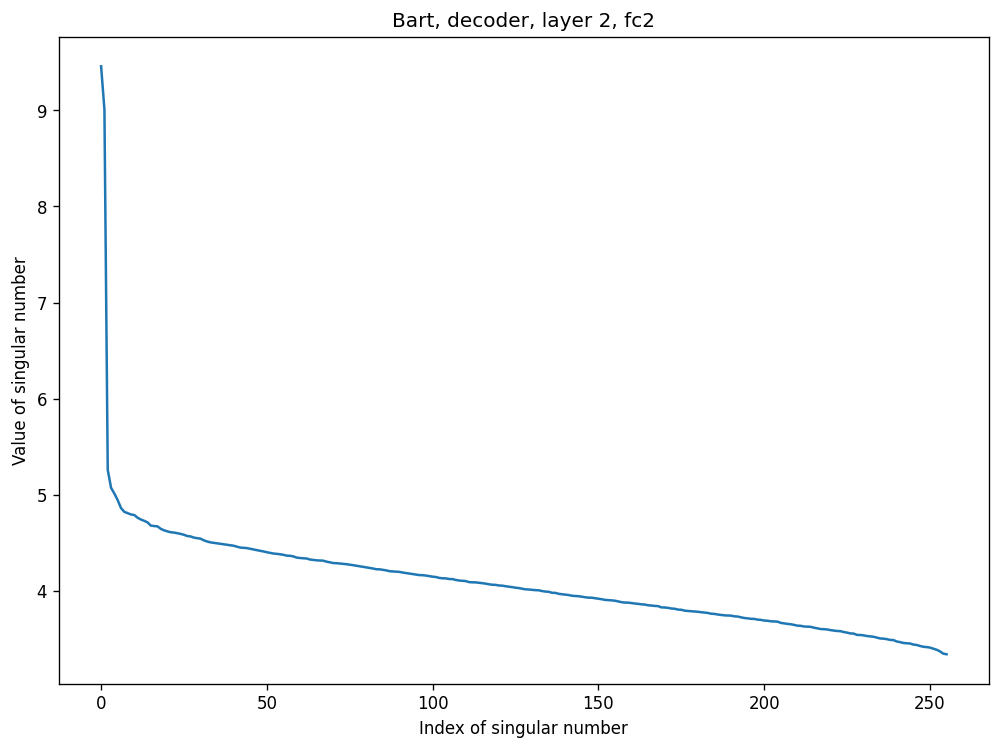

 50%|████████████████████████████████████████████████████████▌                                                        | 3/6 [00:04<00:04,  1.65s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


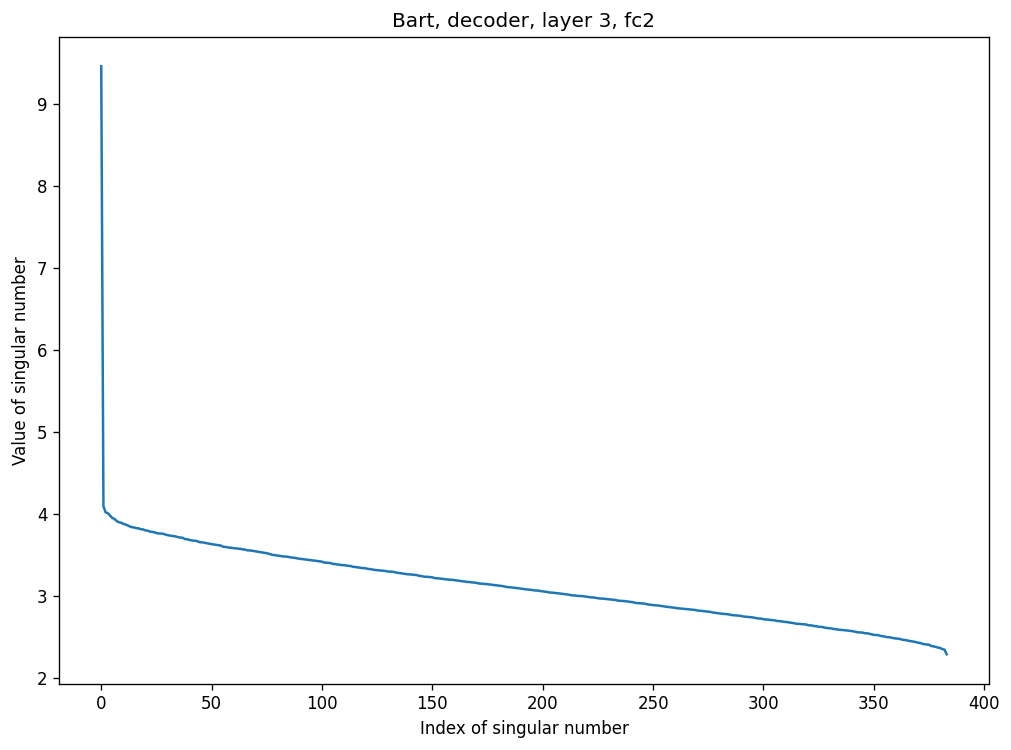

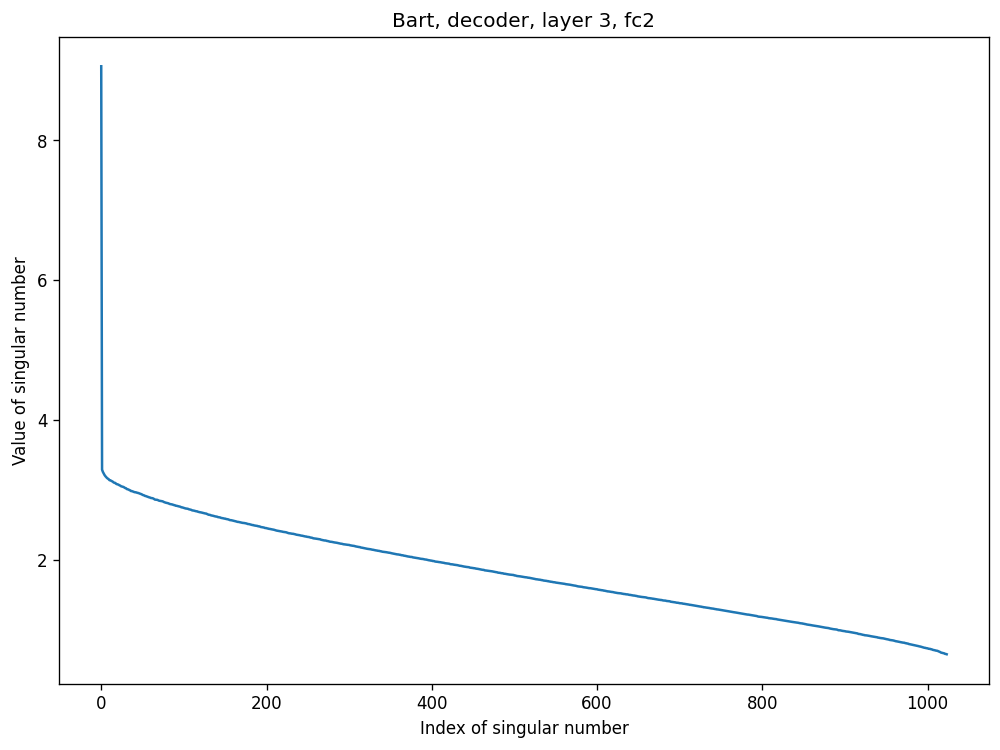

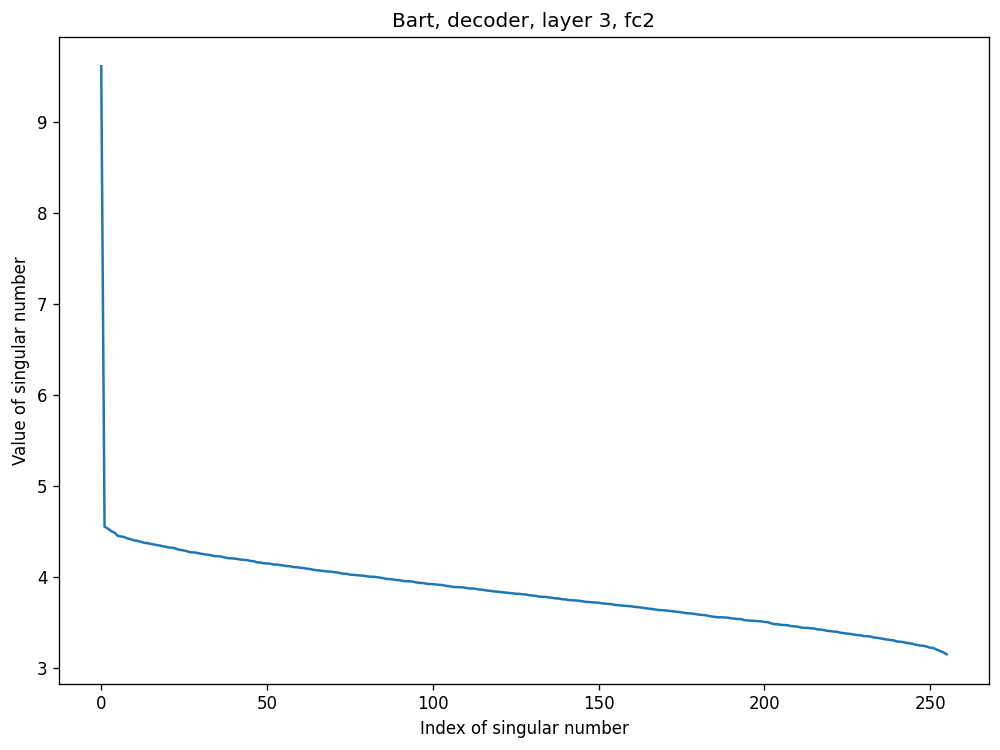

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 4/6 [00:06<00:03,  1.66s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


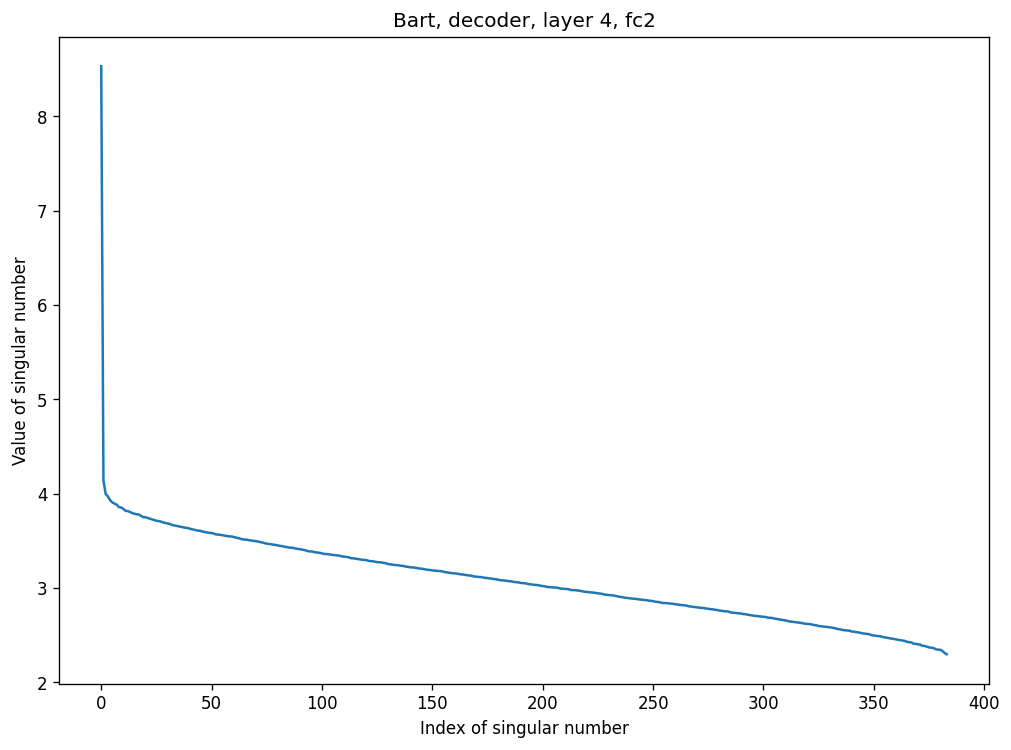

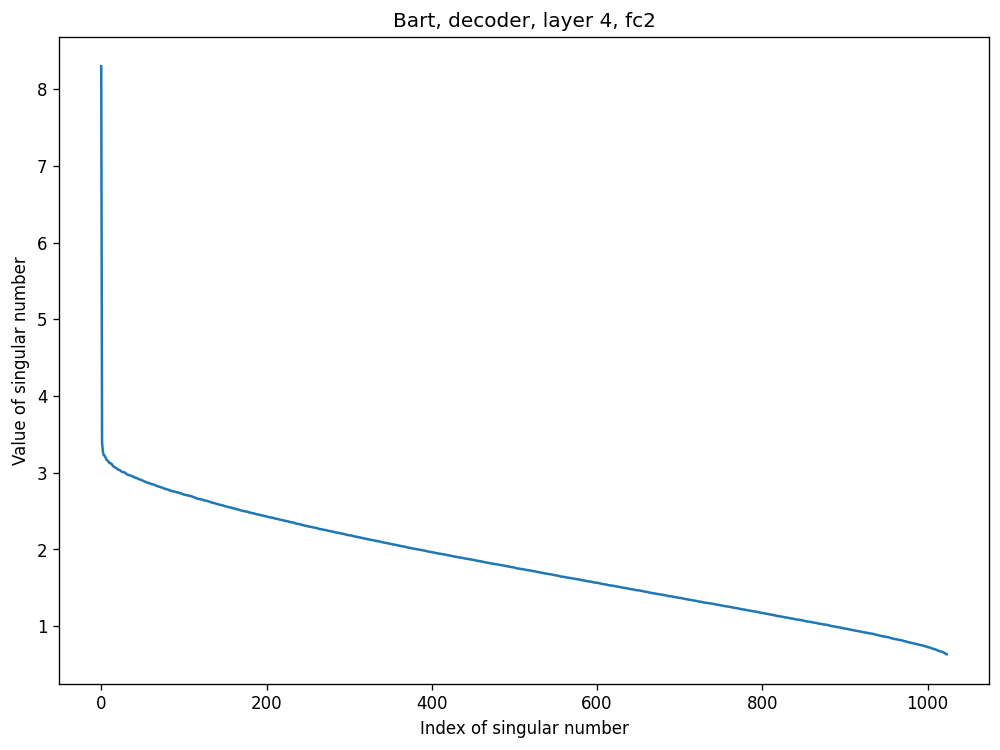

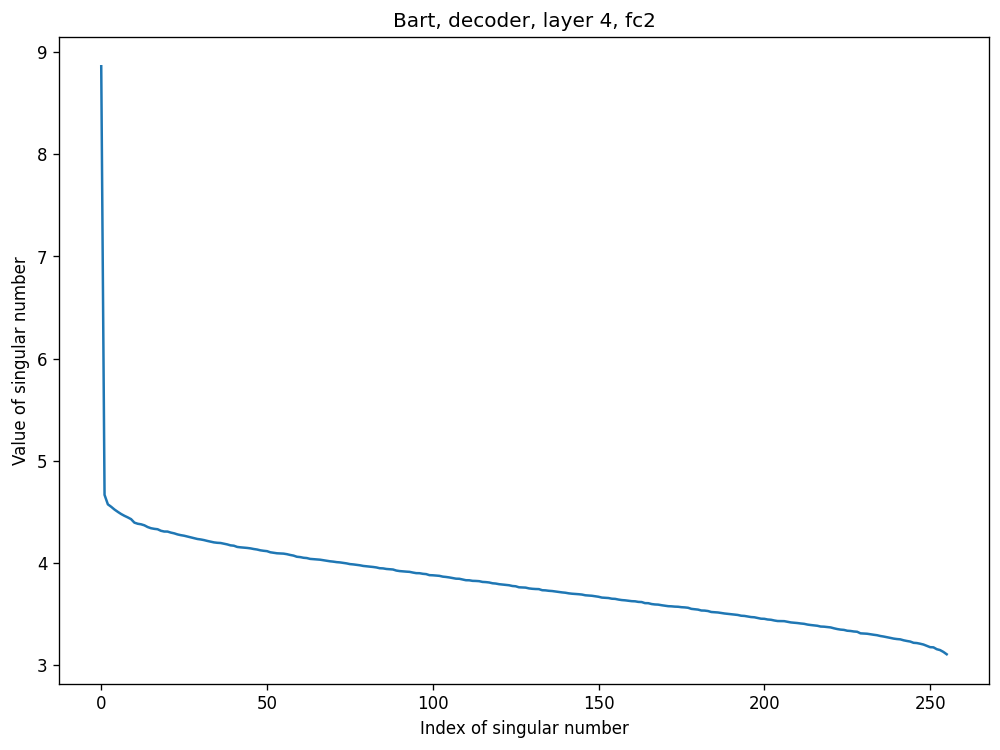

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5/6 [00:08<00:01,  1.75s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


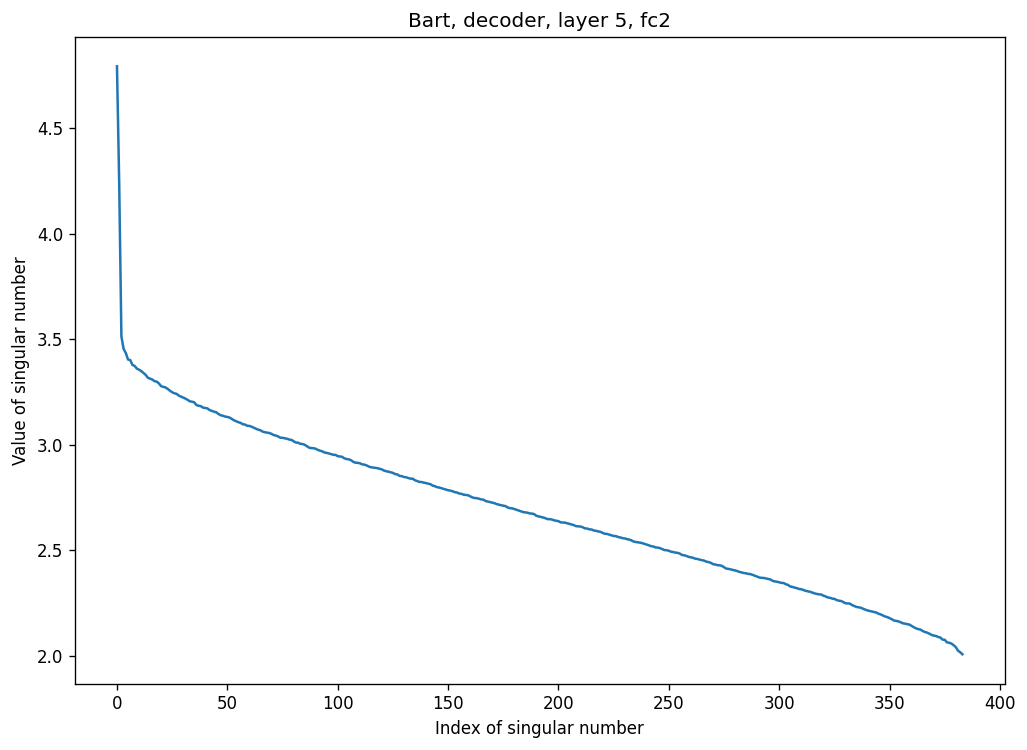

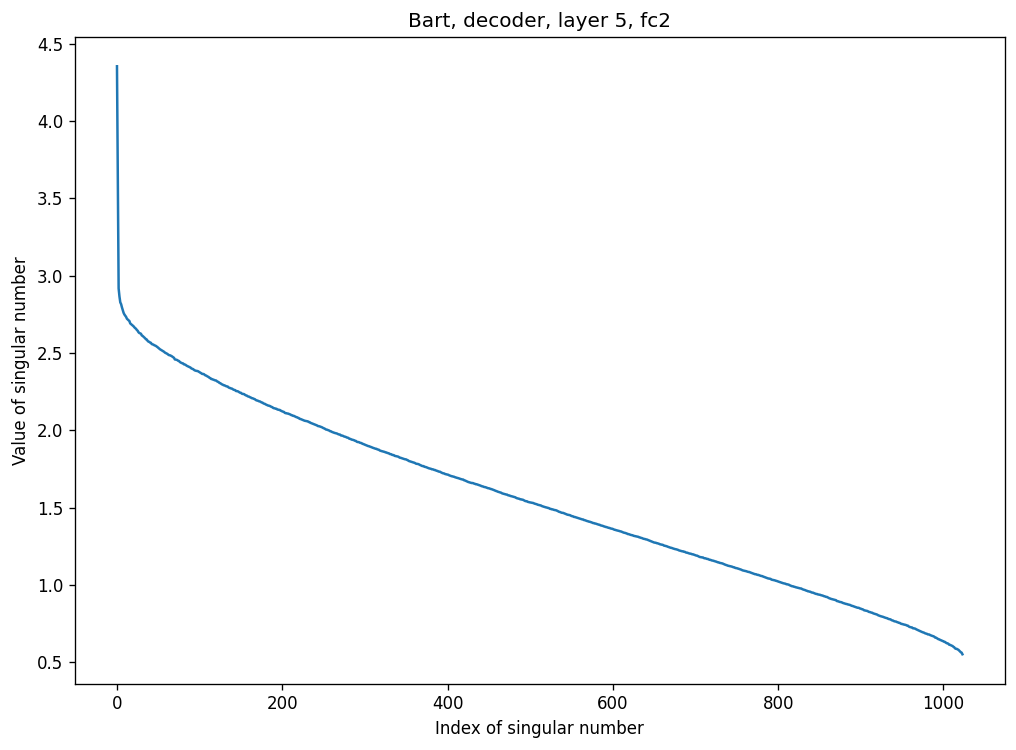

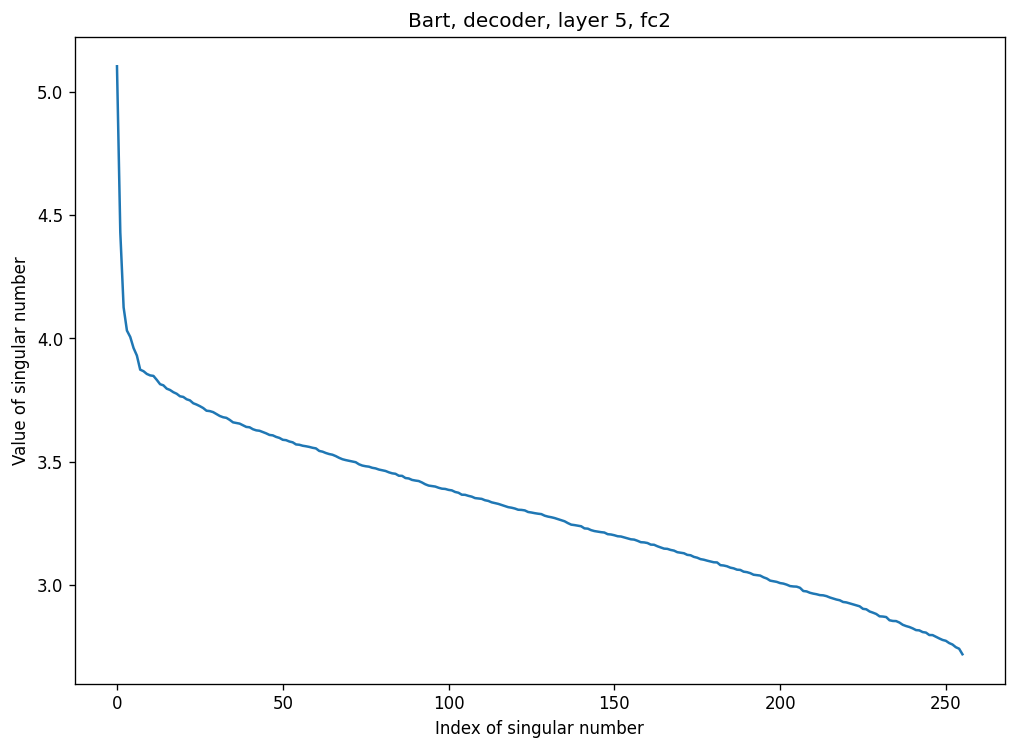

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]


In [33]:
ds = make_dataset_bart(bart.model, "decoder", "fc2", layer_to_compress=(0,1,2,3,4,5))
ds.to_csv("bart_decoder_fc2_dataset.csv", index=False)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)


  0%|                                                                                                                         | 0/6 [00:00<?, ?it/s]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


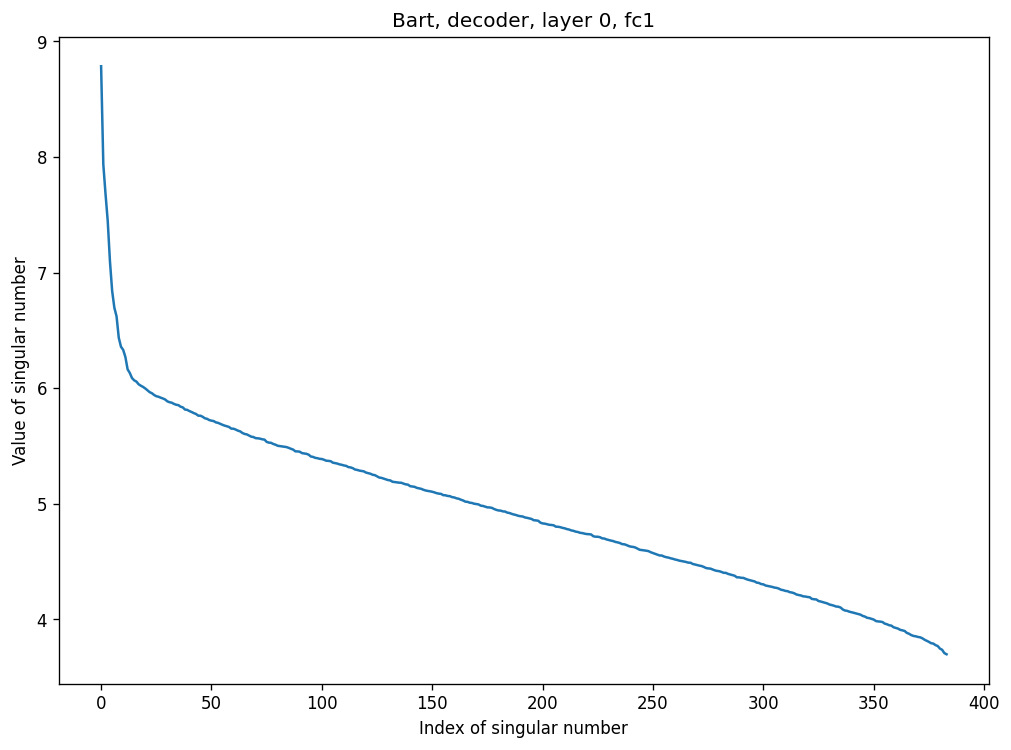

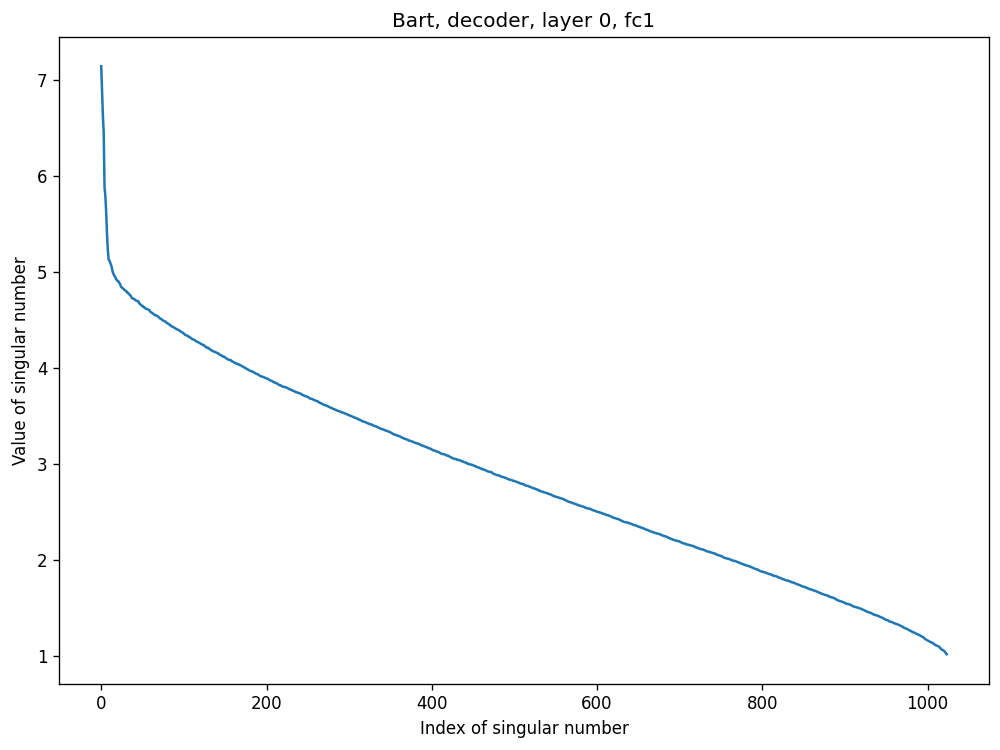

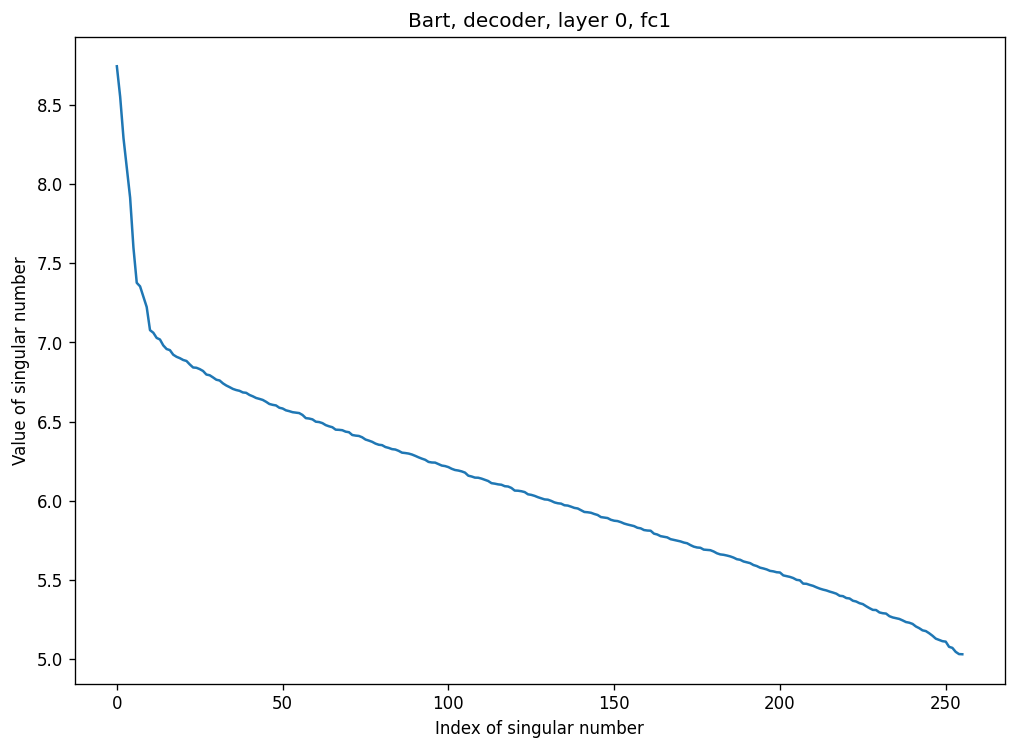

 17%|██████████████████▊                                                                                              | 1/6 [00:01<00:08,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


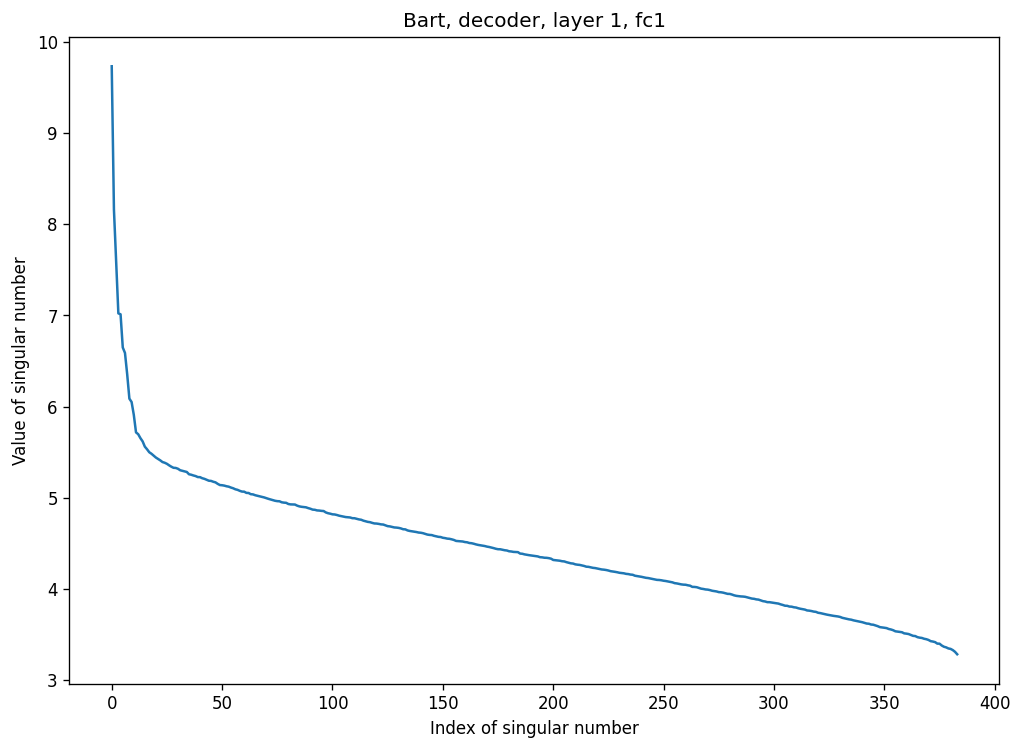

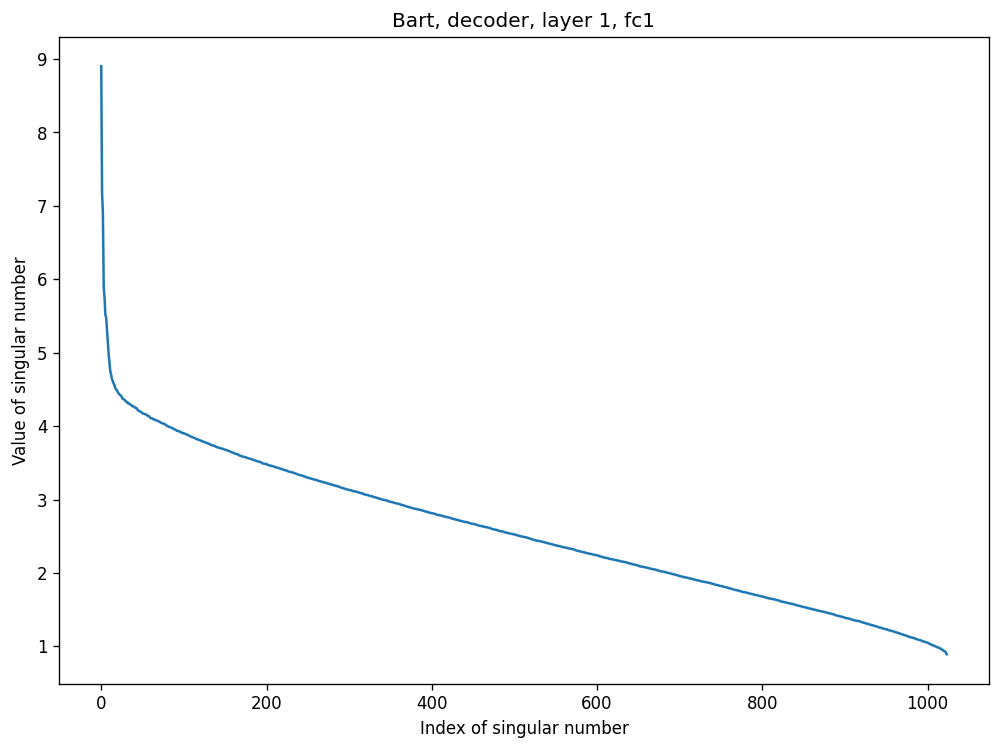

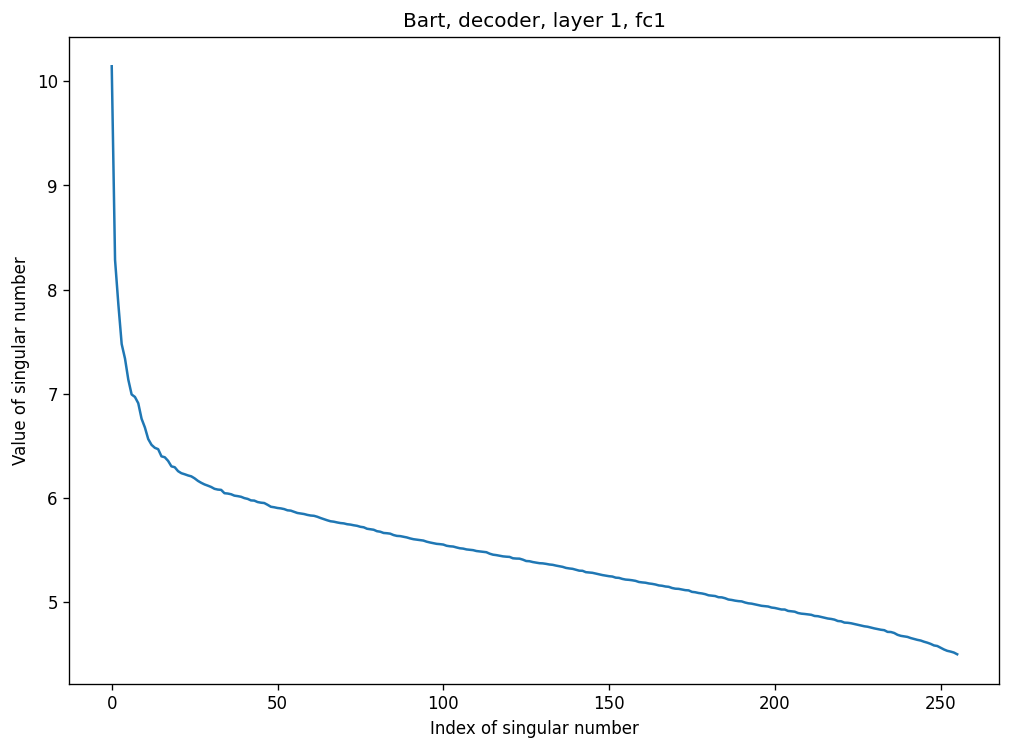

 33%|█████████████████████████████████████▋                                                                           | 2/6 [00:03<00:06,  1.70s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


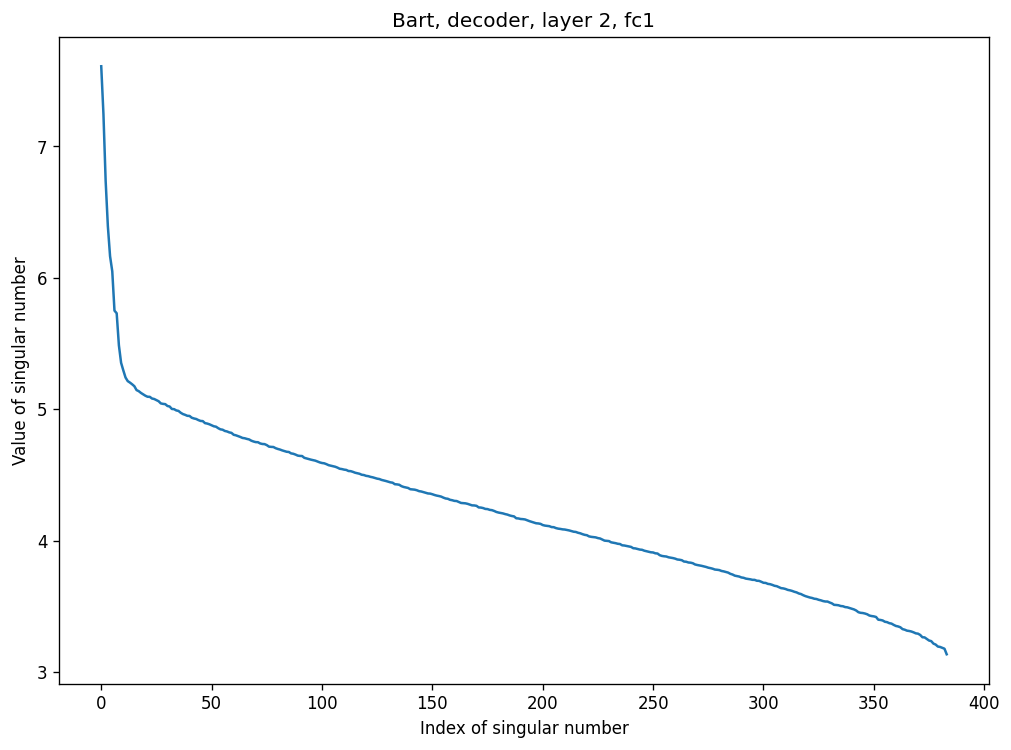

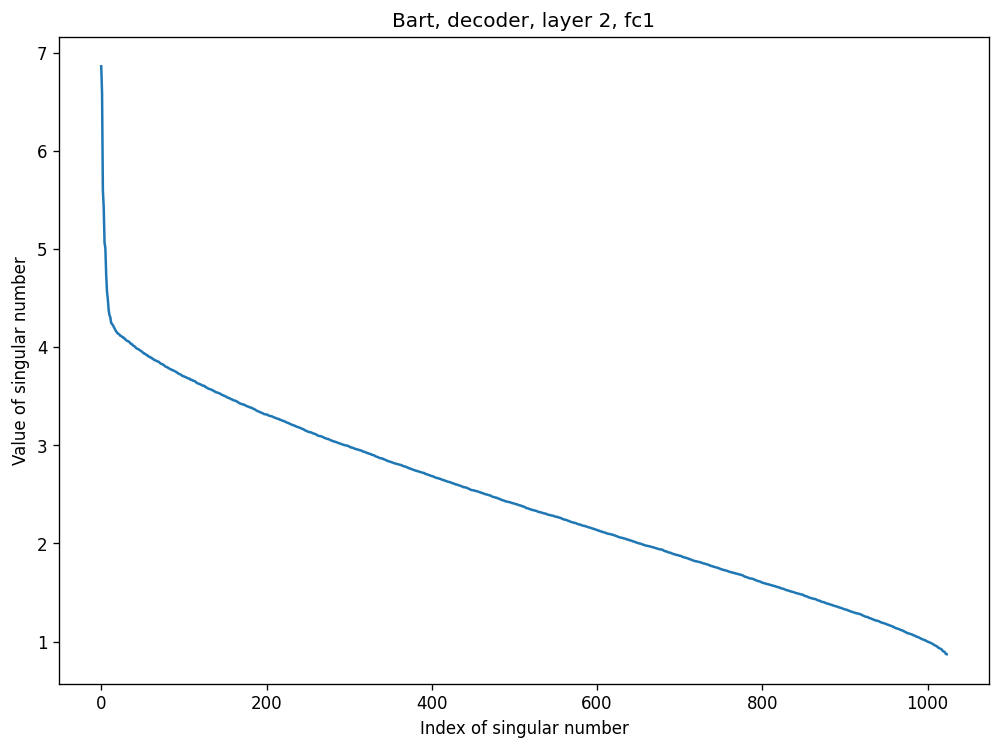

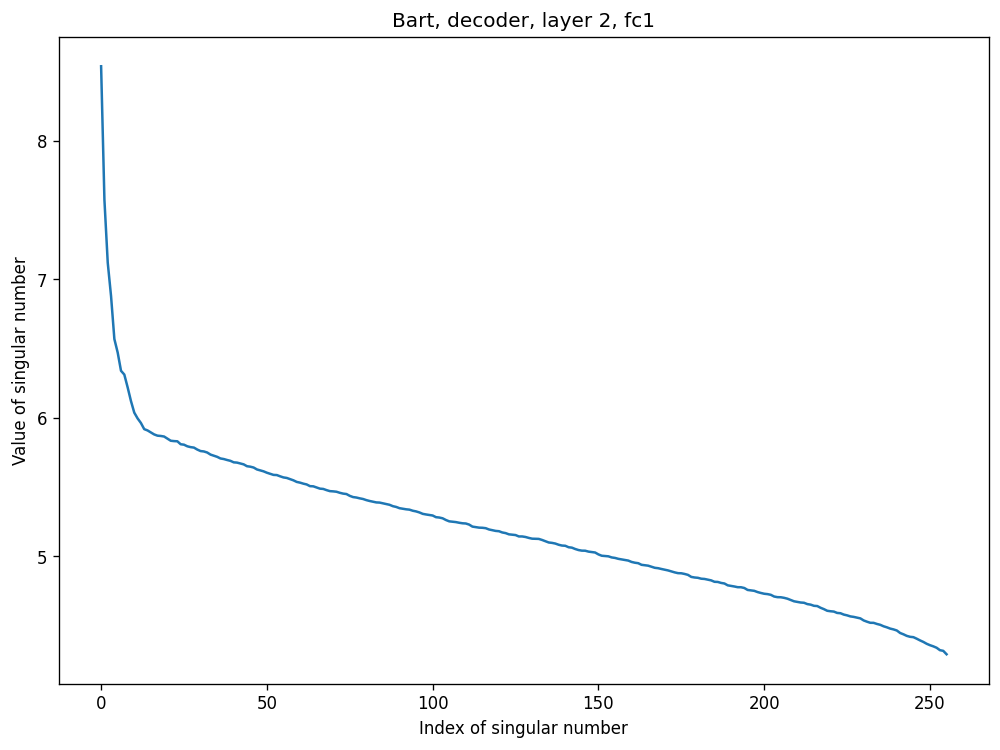

 50%|████████████████████████████████████████████████████████▌                                                        | 3/6 [00:04<00:04,  1.65s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


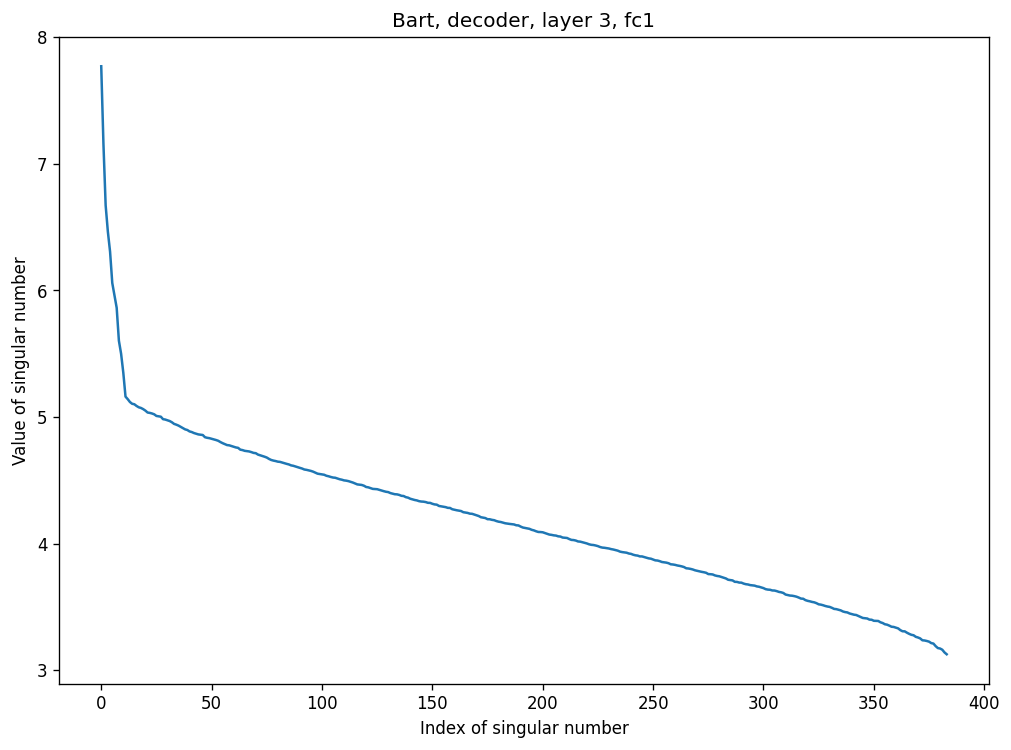

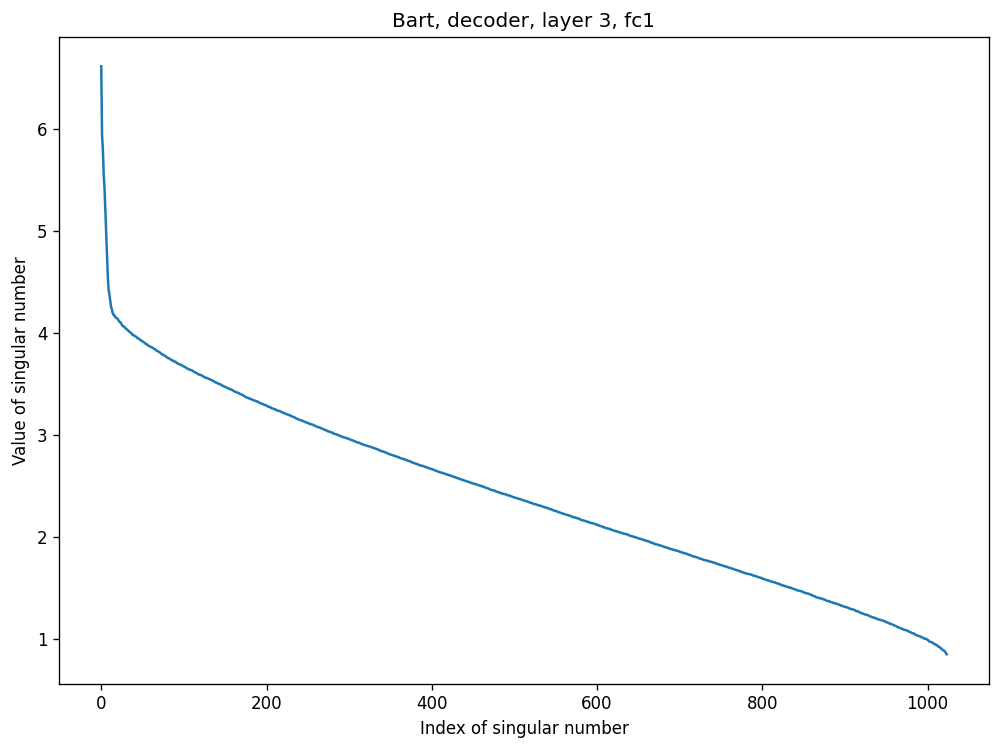

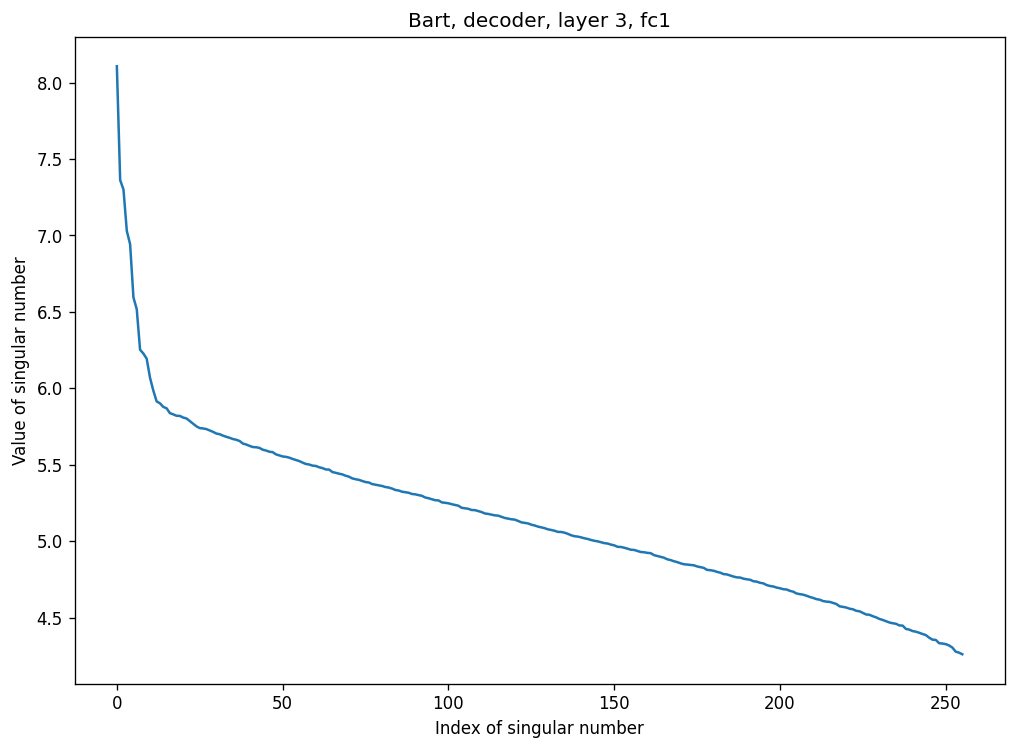

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 4/6 [00:06<00:03,  1.65s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


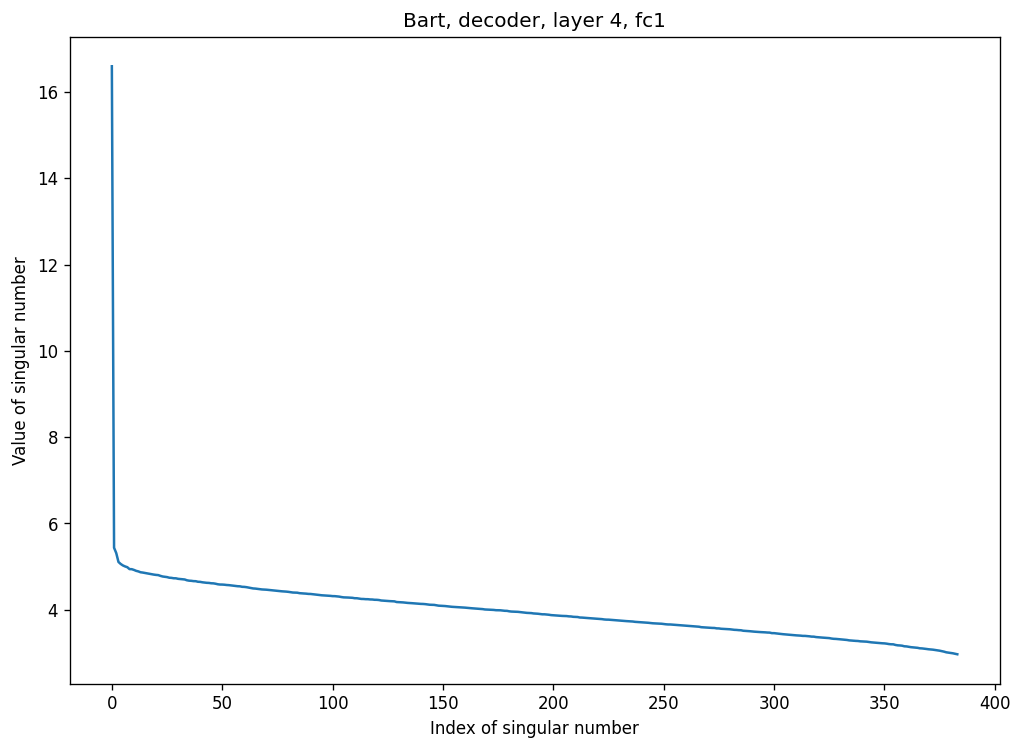

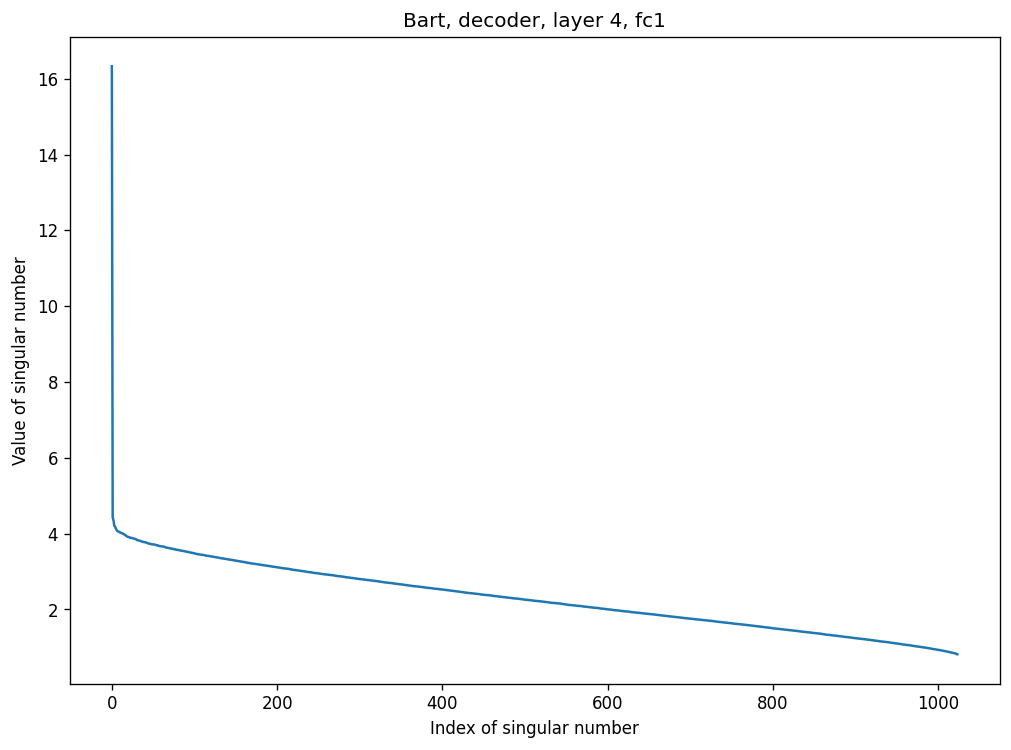

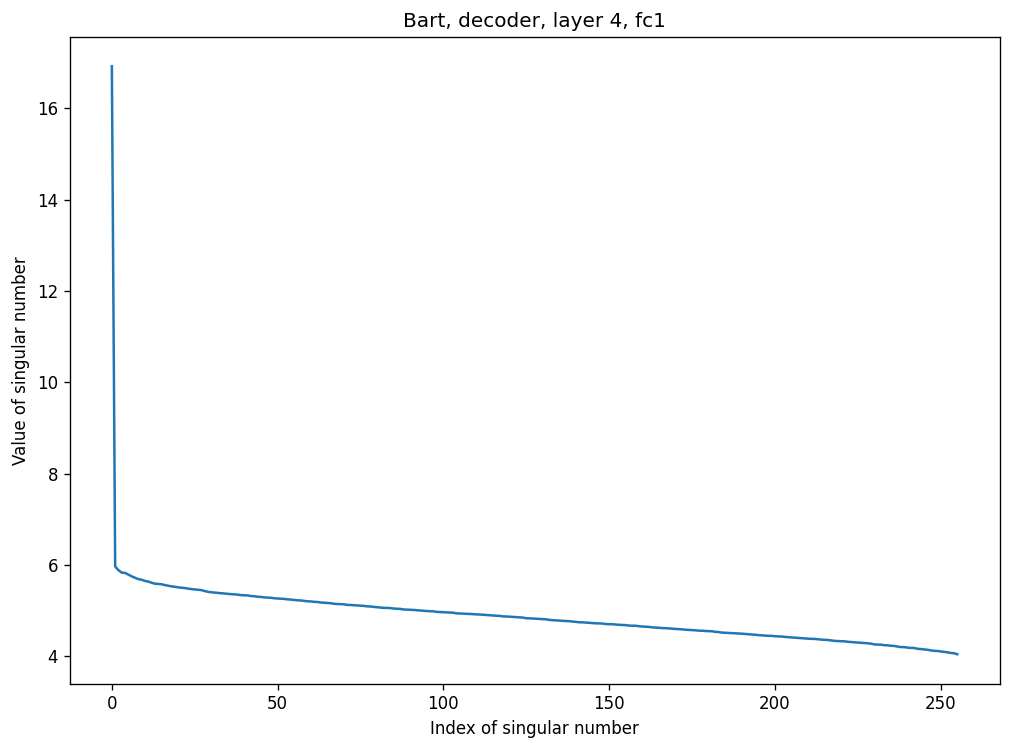

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5/6 [00:08<00:01,  1.66s/it]

rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


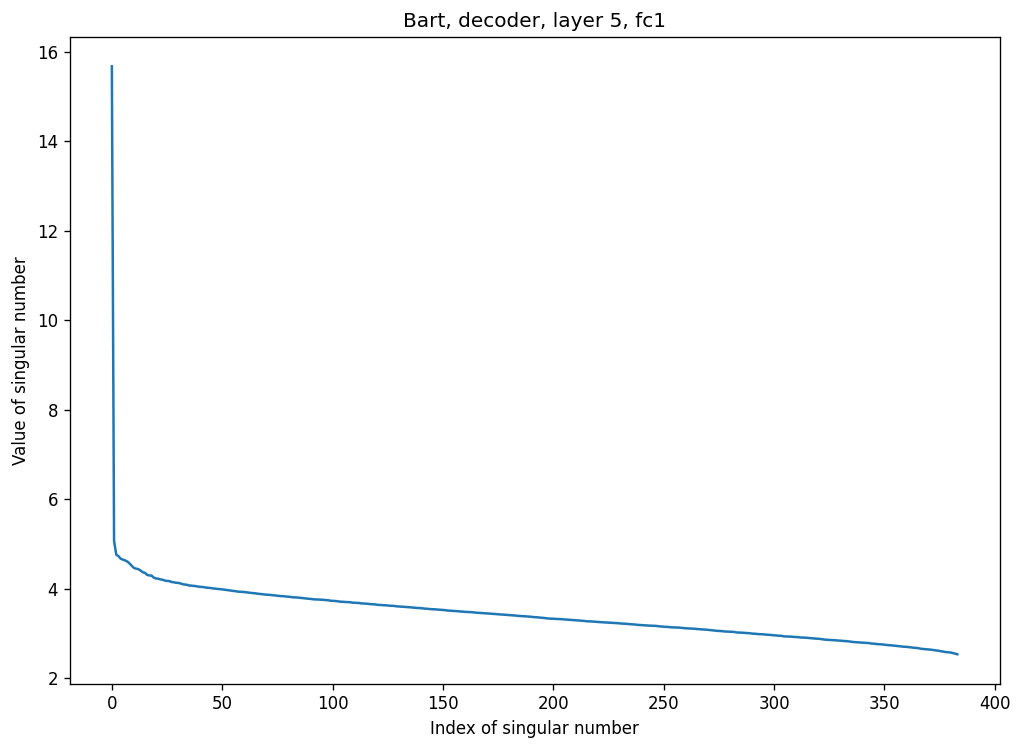

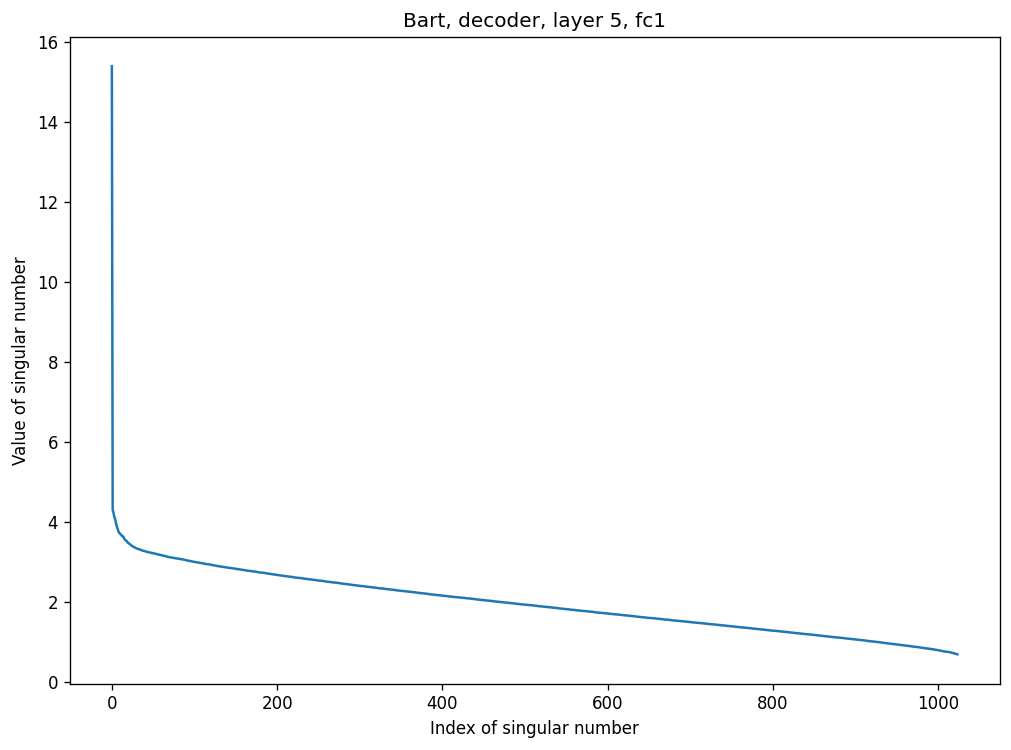

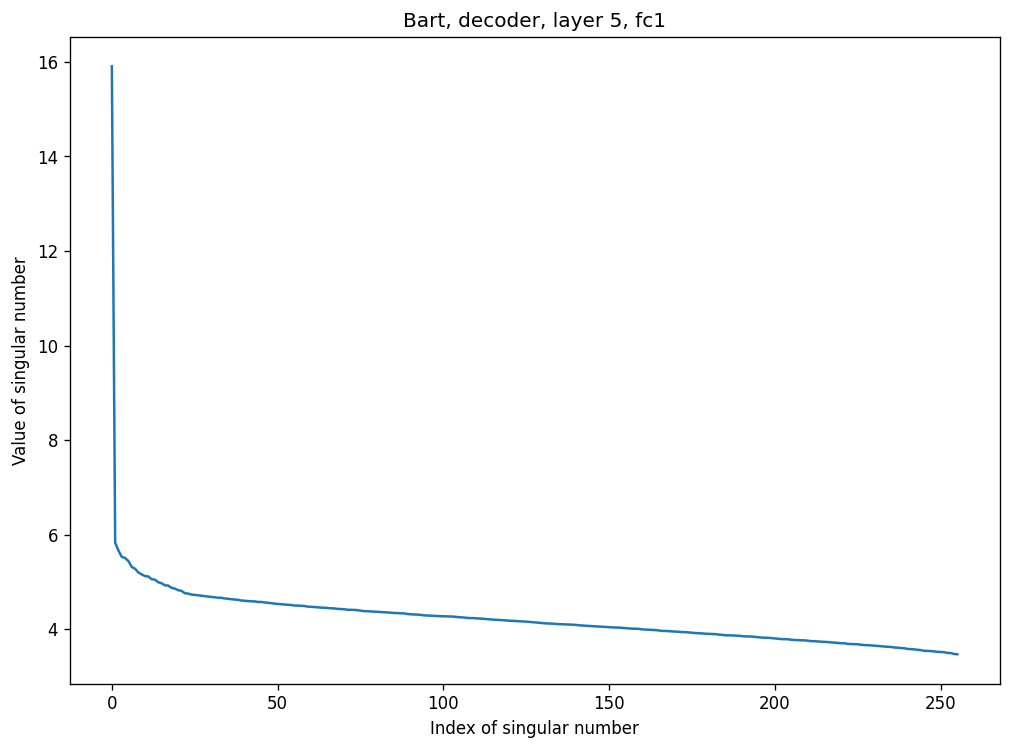

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


In [34]:
ds = make_dataset_bart(bart.model, "decoder", "fc1", layer_to_compress=(4,5))
ds.to_csv("bart_decoder_fc1_dataset.csv", index=False)

## Get colbert weights

# encoder

In [9]:
fc_w = colbert.bert.encoder.layer[1].intermediate.dense

NameError: name 'colbert' is not defined

In [ ]:
a.set_weight(fc_w.weight)

In [3]:
a = TTLinear(in_features = 768, out_features = 3072, ranks =[72, 72, 72] , input_dims = [6, 4, 4 ,8], output_dims= [16, 4, 6, 8])

in ful rank tt data.shape torch.Size([96, 16, 24, 64])
self.cores shape [torch.Size([1, 96, 96]), torch.Size([96, 16, 1536]), torch.Size([1536, 24, 64]), torch.Size([64, 64, 1])]
in round tt cores
torch.Size([1, 96, 96])
torch.Size([96, 16, 1536])
torch.Size([1536, 24, 64])
torch.Size([64, 64, 1])


In [6]:
fc_w = colbert.bert.encoder.layer[0].intermediate.dense

In [ ]:
a.set_weight(fc_w.weight)

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)
layer  0
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


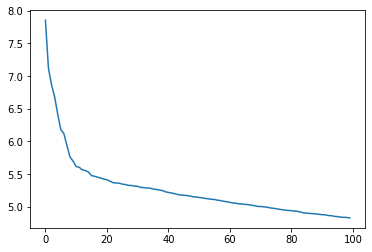

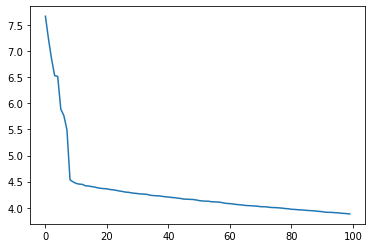

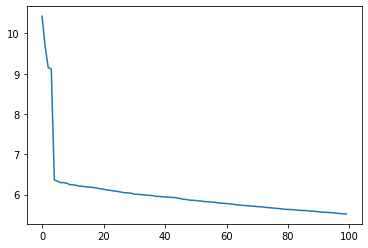



layer  1
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


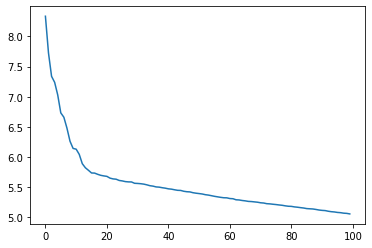

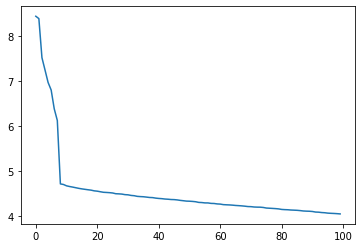

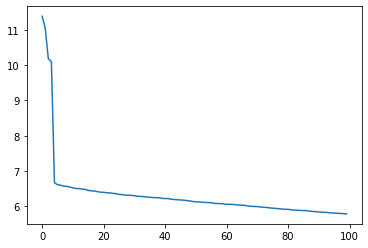



layer  2
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


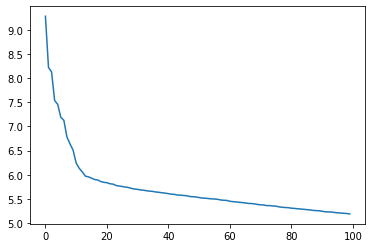

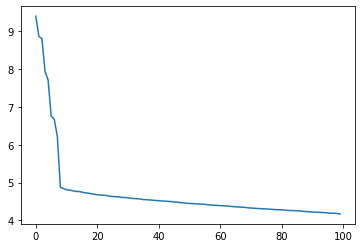

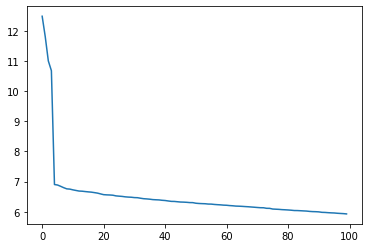



layer  3
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


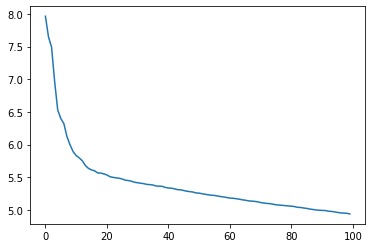

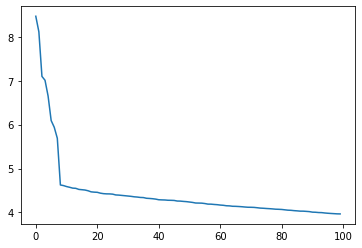

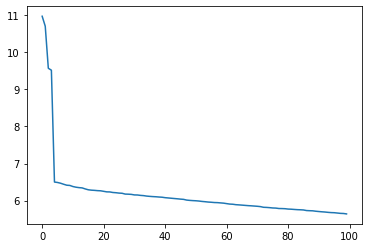



layer  4
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


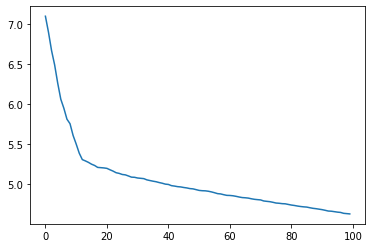

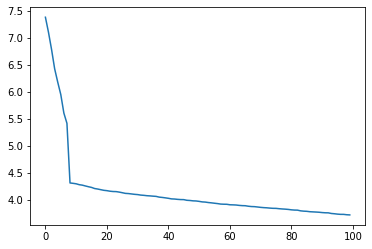

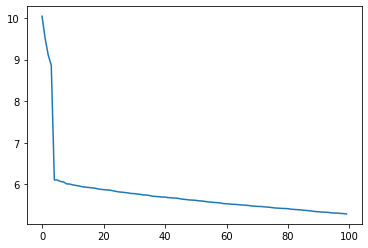



layer  5
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


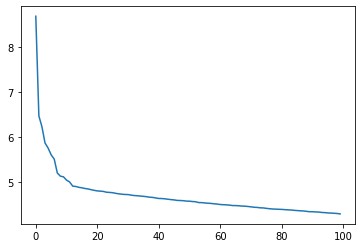

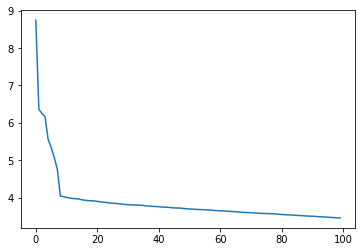

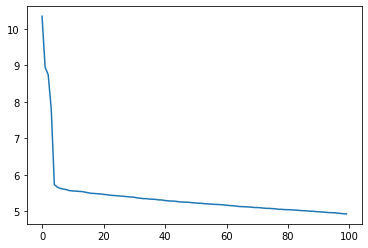

In [17]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(32, 3, 2, 16),  # Column dimention.
(12, 2, 2, 16),  # Row dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)


for ind, elem in enumerate(bert.model.encoder.layers):
    print ("layer ", ind)
    fc_w = bert.model.encoder.layers[ind].fc1
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)
layer  0
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


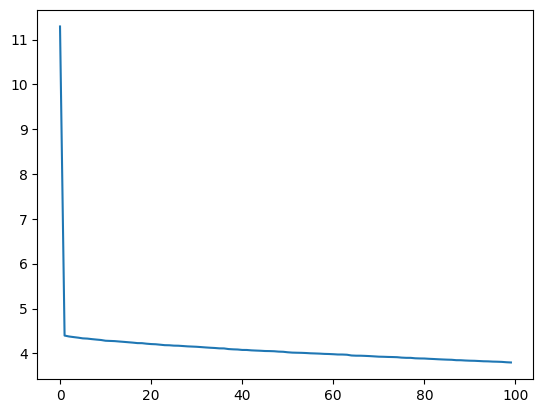

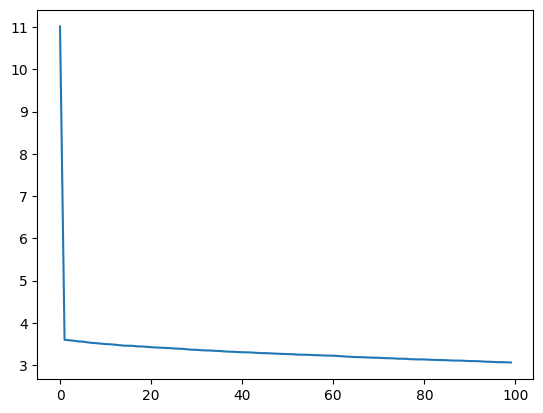

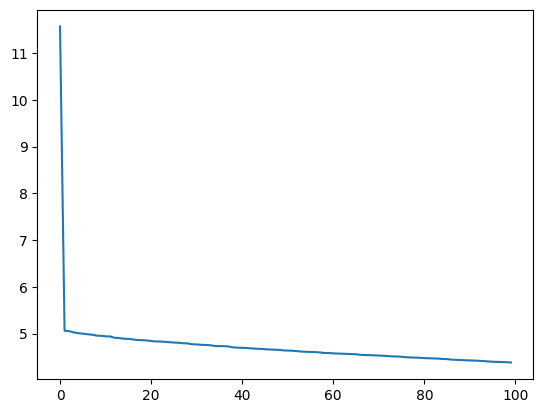



layer  1
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


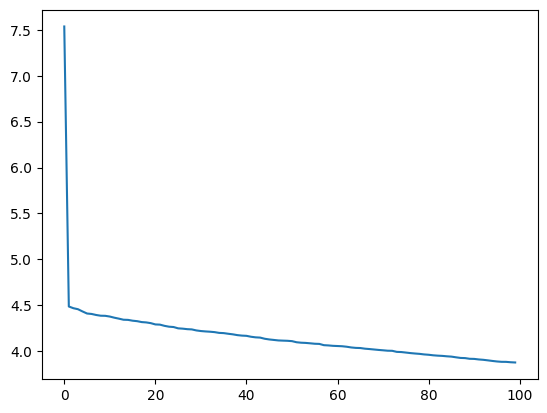

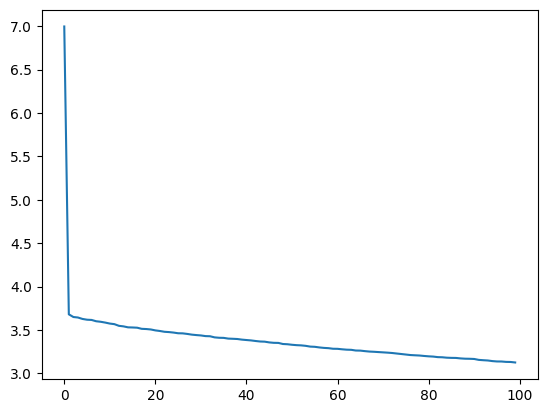

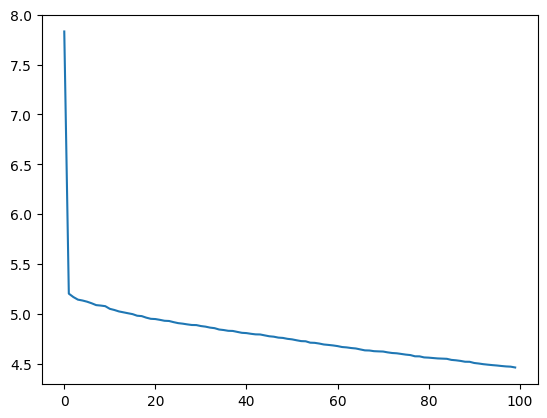



layer  2
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


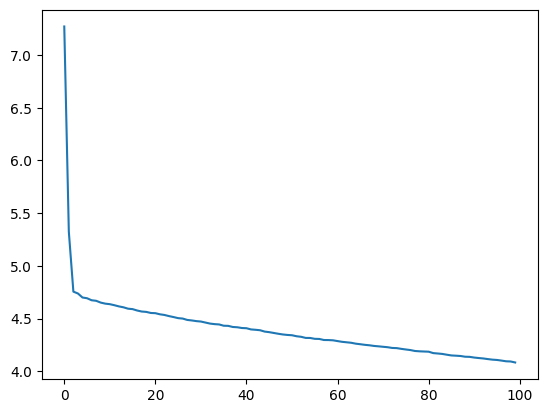

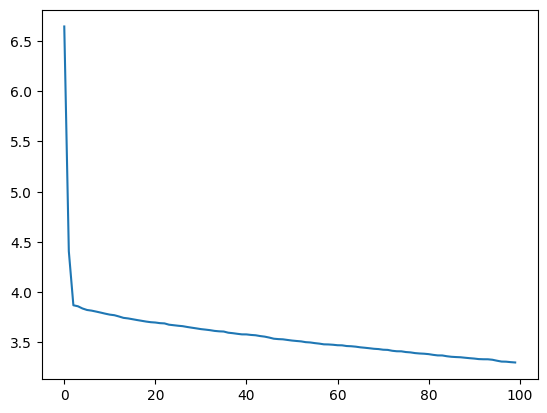

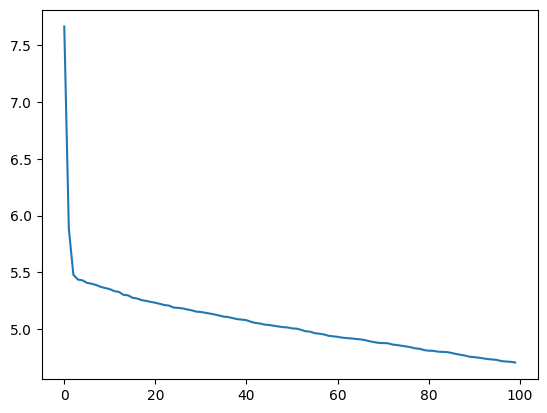



layer  3
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


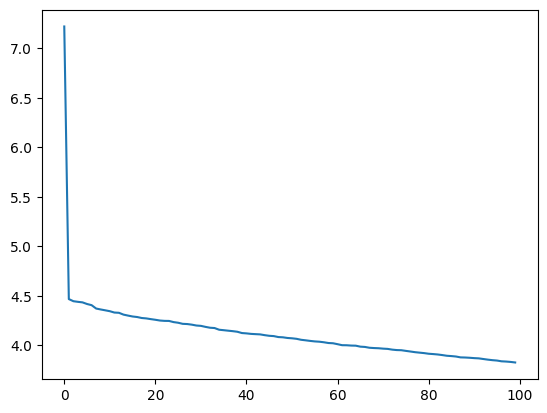

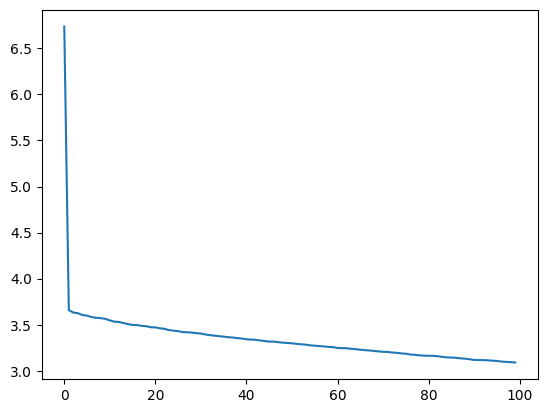

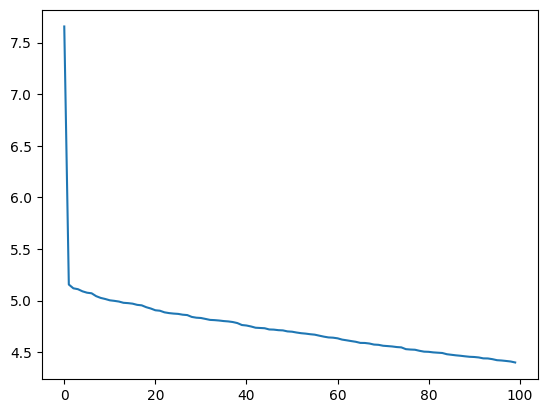



layer  4
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


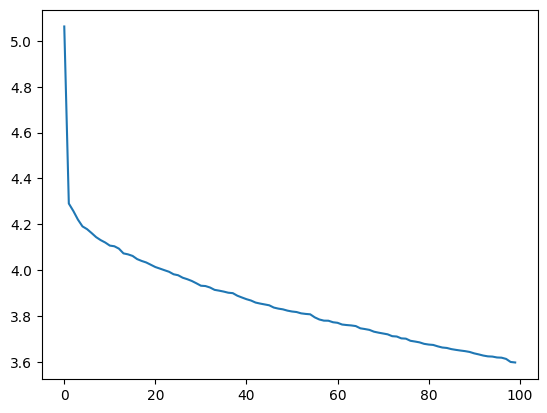

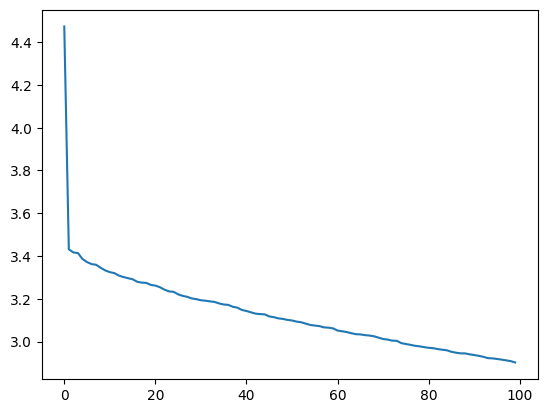

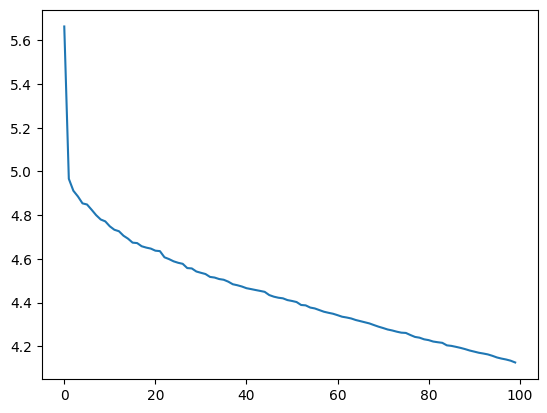



layer  5
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


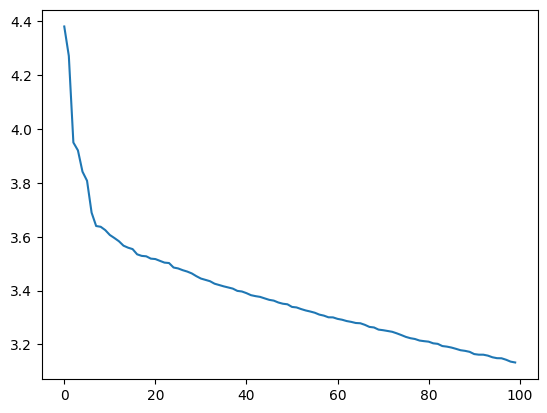

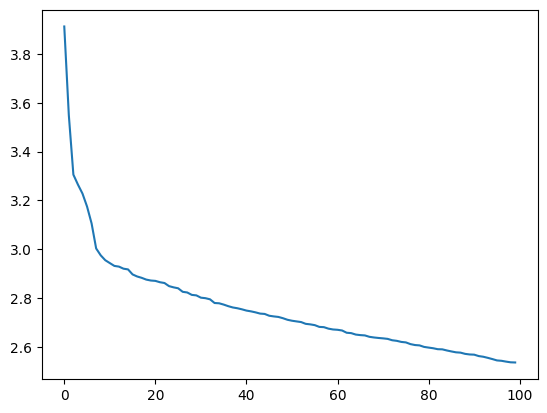

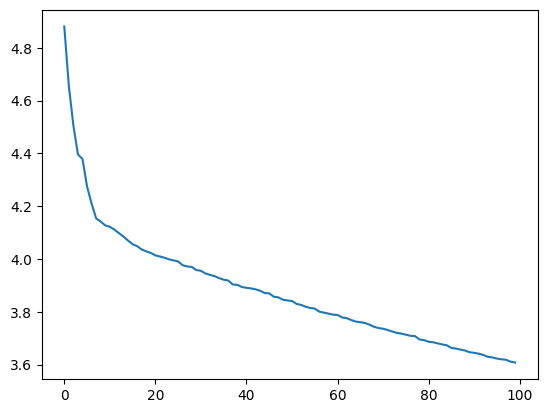

In [10]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(12, 2, 2, 16),  # Row dimention.
(32, 3, 2, 16),  # Column dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)


for ind, elem in enumerate(bert.model.encoder.layers):
    print ("layer ", ind)
    fc_w = bert.model.encoder.layers[ind].fc2
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")

## decoder

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)
layer  0
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


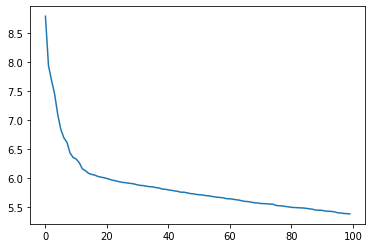

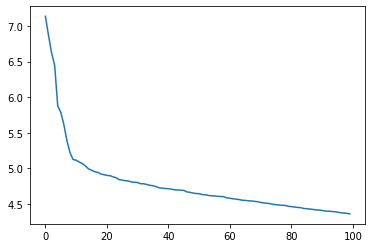

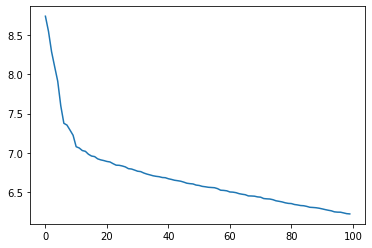



layer  1
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


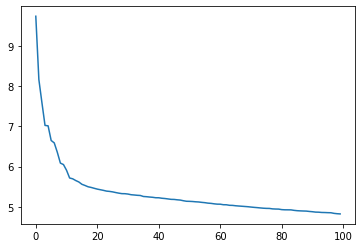

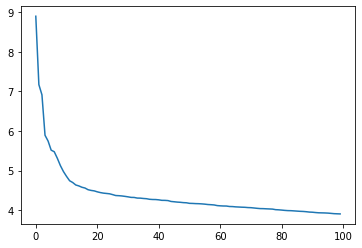

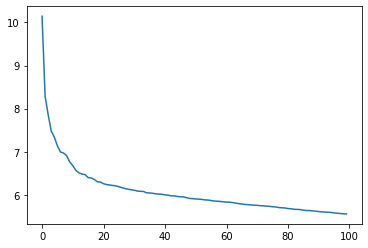



layer  2
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


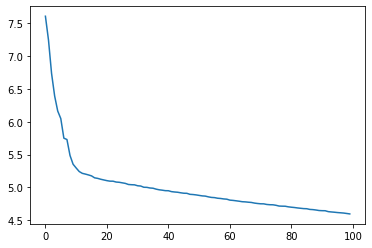

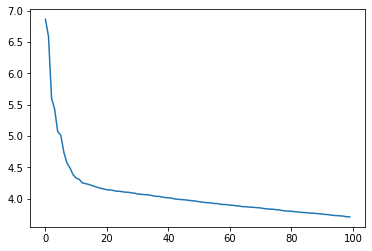

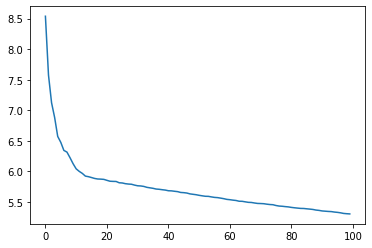



layer  3
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


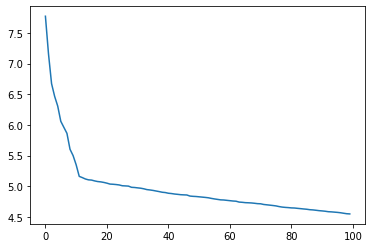

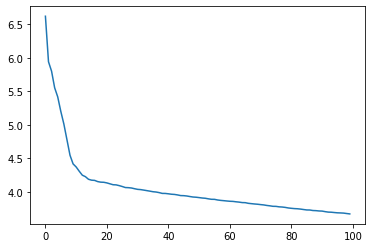

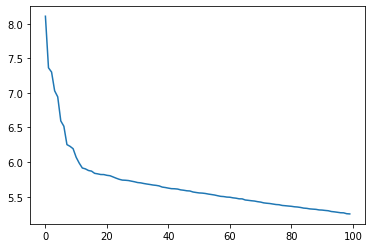



layer  4
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


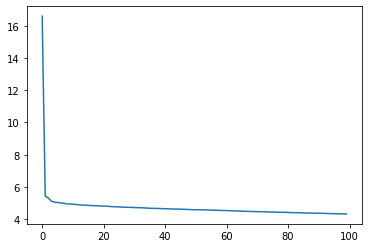

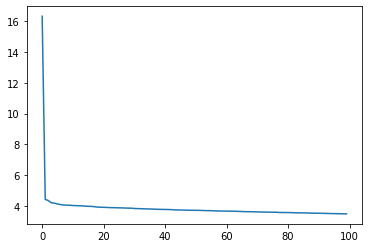

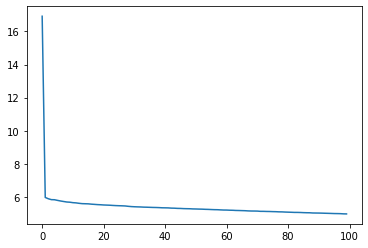



layer  5
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


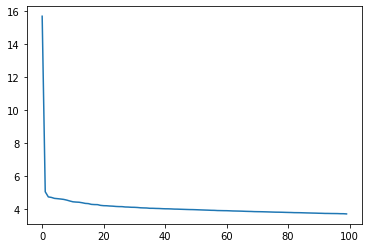

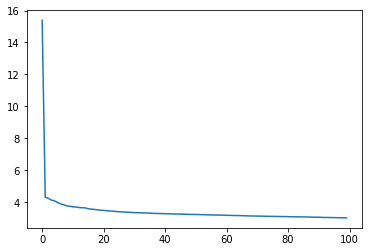

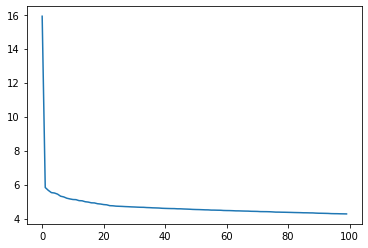

In [19]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(12, 2, 2, 16),  # Row dimention.
(32, 3, 2, 16),  # Column dimention.
)

layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)


for ind, elem in enumerate(bert.model.encoder.layers):
    print ("layer ", ind)
    fc_w = bert.model.decoder.layers[ind].fc1
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")

layer  0
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


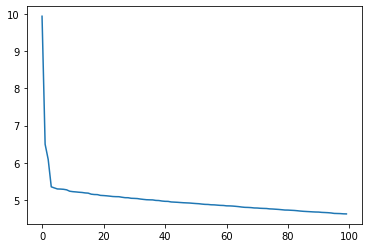

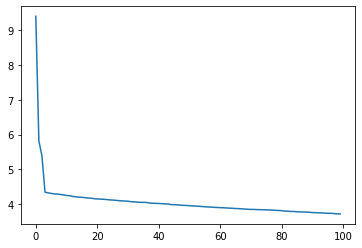

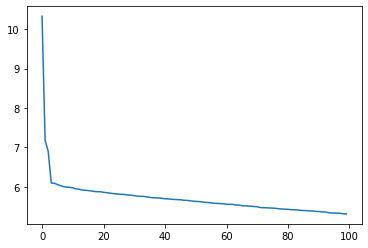



layer  1
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


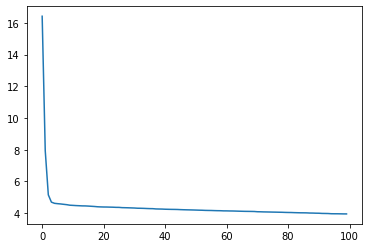

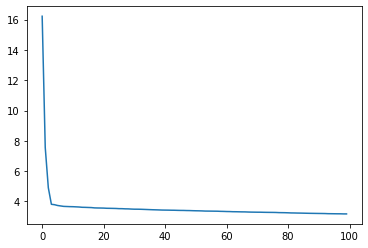

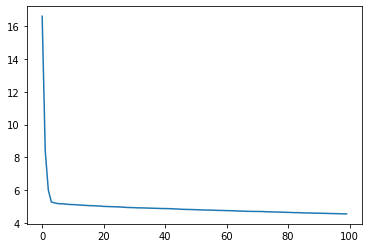



layer  2
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


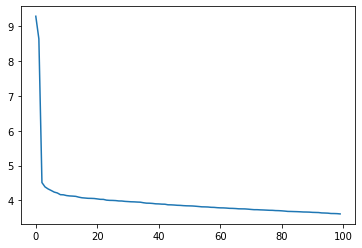

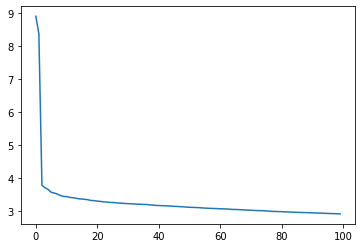

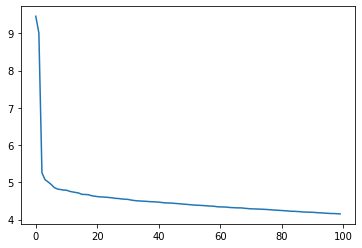



layer  3
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


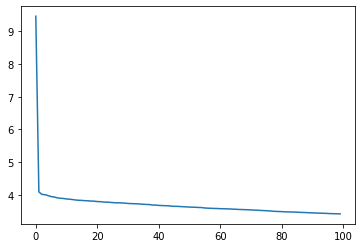

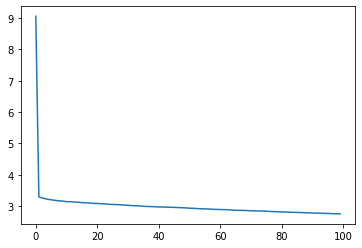

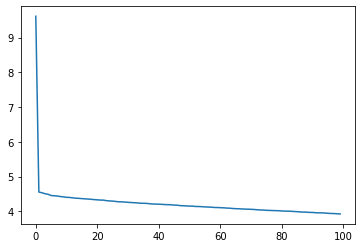



layer  4
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


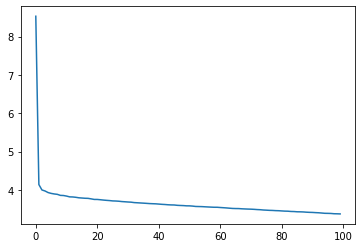

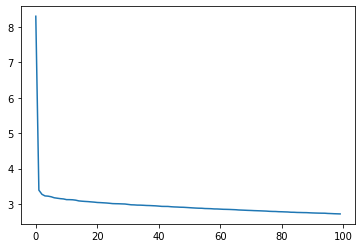

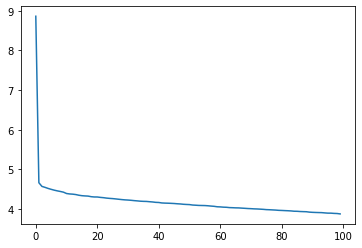



layer  5
rank, shape (1, 72, 72, 72, 1) ((12, 2, 2, 16), (32, 3, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


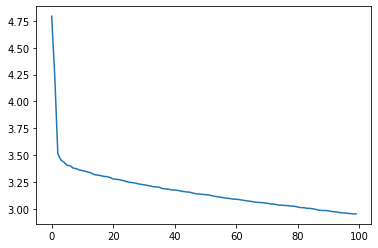

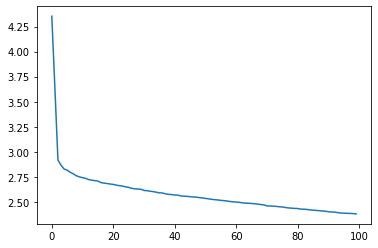

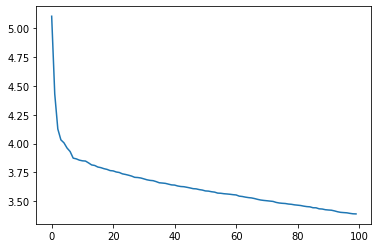

In [20]:
for ind, elem in enumerate(bert.model.encoder.layers):
    print ("layer ", ind)
    fc_w = bert.model.decoder.layers[ind].fc2
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")

core shape1 (1, 384, 72)
core shape1 (72, 6, 72)
core shape1 (72, 4, 72)
core shape1 (72, 256, 1)
layer  0
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


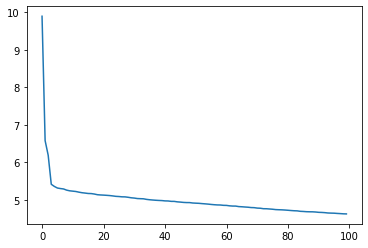

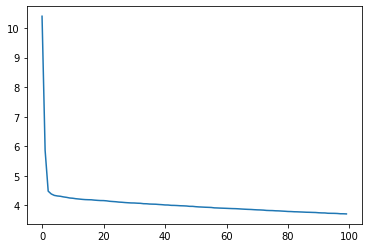

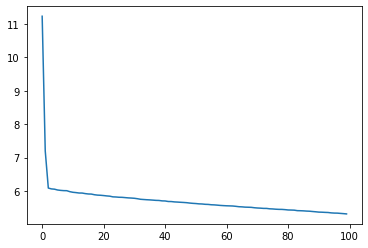



layer  1
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


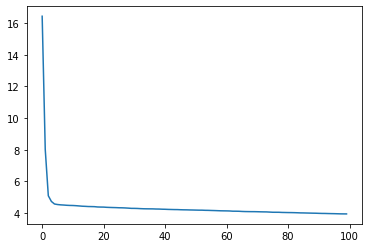

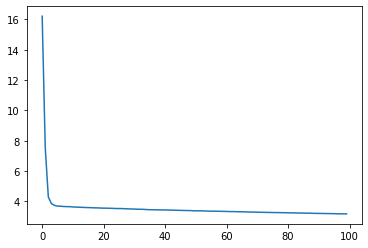

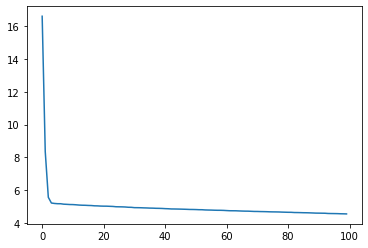



layer  2
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


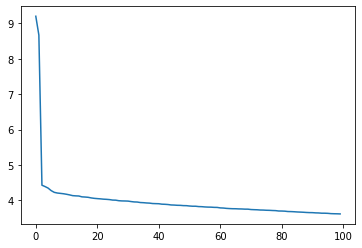

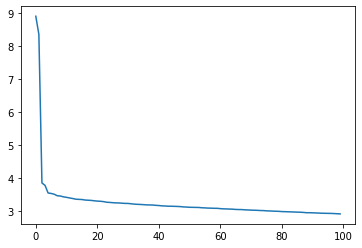

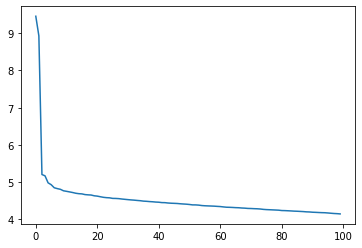



layer  3
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


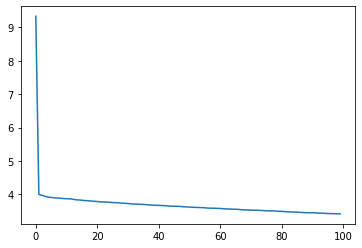

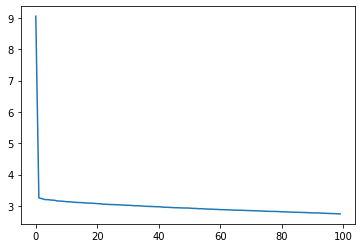

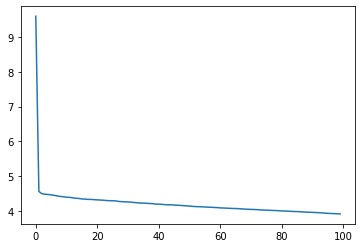



layer  4
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


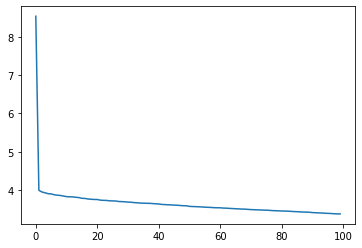

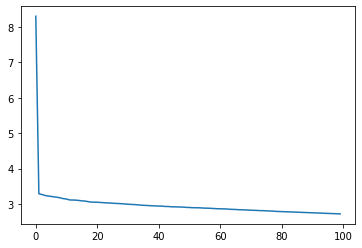

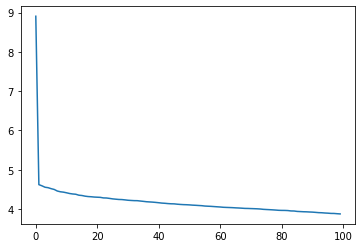



layer  5
rank, shape (1, 72, 72, 72, 1) ((32, 3, 2, 16), (12, 2, 2, 16))
tt_rank, tt_shape (1, (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), (1, 72, 72, 72, 1), 1) (384, 6, 4, 256)
ten shape before torch.Size([384, 6, 4, 256])
first, second 384 6144
shapes before [384, 6, 4, 256]
shapes after torch.Size([384, 6144])
first, second 2304 1024
shapes before [384, 6, 4, 256]
shapes after torch.Size([2304, 1024])
first, second 9216 256
shapes before [384, 6, 4, 256]
shapes after torch.Size([9216, 256])


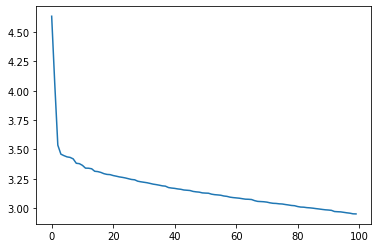

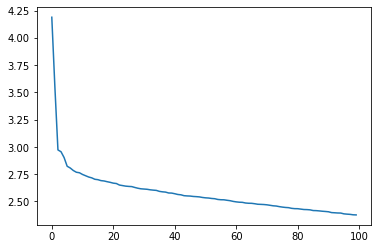

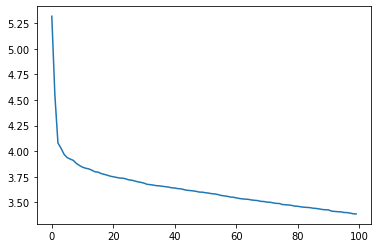

In [23]:
import matplotlib.pyplot as plt
rank = 72  # Uniform TT-rank.
shape = (
(32, 3, 2, 16),  # Column dimention.
(12, 2, 2, 16),  # Row dimention.
)


layer = TTCompressedLinear.from_linear(fc_w, shape=shape, rank=rank)


for ind, elem in enumerate(bert.model.encoder.layers):
    print ("layer ", ind)
    fc_w = bert.model.decoder.layers[ind].fc2
    s_values=layer.get_proper_rank(matrix=fc_w.weight.data.T) 
    for elem in s_values:
        plt.plot(elem[:100])
        plt.show()
    print ("\n")